In [ ]:
import seaborn as sns

In [ ]:
import pandas as pd
import glob
import os

In [6]:
df=pd.read_csv('/Users/hassaanulhaq/Library/Mobile Documents/com~apple~CloudDocs/spring_2025/GIS/final_project/data/co_data/merged_file.csv')


In [ ]:
type(df)


In [ ]:
type(df['Date'])
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')



In [15]:
df['Year'] = df['Date'].dt.year
df['Month_Year'] = df['Date'].dt.to_period('M')

In [16]:
df_cook = df[df['County'] == "Cook"]

In [19]:
# Extract unique site names with their latitude and longitude
site_coords = df_cook[['Local Site Name', 'Site Latitude', 'Site Longitude']].drop_duplicates()

# Merge the monthly data with the site coordinates
df_cook_monthly = df_cook.groupby(['Local Site Name', 'Month_Year'])['Daily AQI Value'].mean().reset_index()
df_cook_monthly.rename(columns={'Daily AQI Value': 'monthly_value'}, inplace=True)
df_cook_monthly = df_cook_monthly.merge(site_coords, on='Local Site Name', how='left')

In [95]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
from shapely.geometry import Point
import folium
from folium.plugins import TimestampedGeoJson

import matplotlib.pyplot as plt
import branca.colormap as cm

def process_dataset(file_path, county_name, pollutant_column, date_column, site_name_column, latitude_column, longitude_column):
    # Load the dataset
    df = pd.read_csv(file_path)
    
    # Convert the date column to datetime
    df[date_column] = pd.to_datetime(df[date_column], errors='coerce')
    
    # Extract year and month-year
    df['Year'] = df[date_column].dt.year
    df['Month_Year'] = df[date_column].dt.to_period('M')
    
    # Filter data for the specified county
    df_county = df[df['County'] == county_name]
    
    # Extract unique site names with their latitude and longitude
    site_coords = df_county[[site_name_column, latitude_column, longitude_column]].drop_duplicates()
    
    # Group data by site and month-year to calculate the monthly average pollutant value
    df_county_monthly = df_county.groupby([site_name_column, 'Month_Year'])[pollutant_column].mean().reset_index()
    df_county_monthly.rename(columns={pollutant_column: 'monthly_value'}, inplace=True)
    df_county_monthly = df_county_monthly.merge(site_coords, on=site_name_column, how='left')
    
    return df, df_county, df_county_monthly, site_coords

def create_time_series_map(df_county_monthly, latitude_column, longitude_column, site_name_column, value_column, month_year_column):
    # Prepare the data for the time series map
    features = []
    for _, row in df_county_monthly.iterrows():
        feature = {
            'type': 'Feature',
            'geometry': {
                'type': 'Point',
                'coordinates': [row[longitude_column], row[latitude_column]],
            },
            'properties': {
                'time': str(row[month_year_column]),
                'popup': f"Site: {row[site_name_column]}<br>Monthly Value: {row[value_column]:.2f}",
                'icon': 'circle',
                'iconstyle': {
                    'fillColor': 'red',
                    'fillOpacity': 0.6,
                    'stroke': 'true',
                    'radius': 8
                }
            }
        }
        features.append(feature)

    # Create a GeoJSON object
    geojson = {
        'type': 'FeatureCollection',
        'features': features
    }

    # Create the folium map
    m = folium.Map(location=[df_county_monthly[latitude_column].mean(), df_county_monthly[longitude_column].mean()], zoom_start=10, tiles='CartoDB positron')

    # Add the time series layer
    TimestampedGeoJson(
        geojson,
        transition_time=200,
        period='P1M',
        add_last_point=True,
        auto_play=False,
        loop=False,
        max_speed=1,
        loop_button=True,
        date_options='YYYY-MM',
        time_slider_drag_update=True
    ).add_to(m)

    # Add a title
    title_html = '''
        <h3 align="center" style="font-size:16px"><b>Time Series of CO Concentration</b></h3>
    '''
    m.get_root().html.add_child(folium.Element(title_html))

    return m

def plot_time_series(df_county_monthly, month_year_column, value_column, site_name_column):
    # Create a line plot for each site
    plt.figure(figsize=(14, 8))
    df_county_monthly[month_year_column] = df_county_monthly[month_year_column].astype(str)
    sns.lineplot(data=df_county_monthly, x=month_year_column, y=value_column, hue=site_name_column, marker='o')

    # Customize the plot
    plt.title("Time Series of CO Concentration by Site", fontsize=16)
    plt.xlabel("Month-Year", fontsize=12)
    plt.ylabel("Monthly Average CO Concentration", fontsize=12)
    plt.xticks(rotation=90)
    plt.legend(title='Local Site Name', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    # Show the plot
    plt.show()

def plot_geospatial_distribution(df_county_monthly, latitude_column, longitude_column, value_column):
    # Create a GeoDataFrame from the monthly data
    geometry = [Point(xy) for xy in zip(df_county_monthly[longitude_column], df_county_monthly[latitude_column])]
    gdf = gpd.GeoDataFrame(df_county_monthly, geometry=geometry)

    # Plot the GeoDataFrame
    fig, ax = plt.subplots(figsize=(12, 8))
    gdf.plot(ax=ax, column=value_column, cmap='coolwarm', legend=True, markersize=50)

    # Customize the plot
    plt.title("Monthly Average CO Concentration (Sites)", fontsize=16)
    plt.xlabel("Longitude", fontsize=12)
    plt.ylabel("Latitude", fontsize=12)
    plt.grid(True)

    # Show the plot
    plt.show()

In [ ]:
!pip install geopandas
!pip install folium


In [ ]:
import folium
from folium.plugins import TimestampedGeoJson
import json

# Prepare the data for the time series map
features = []
for _, row in df_cook_monthly.iterrows():
    feature = {
        'type': 'Feature',
        'geometry': {
            'type': 'Point',
            'coordinates': [row['Site Longitude'], row['Site Latitude']],
        },
        'properties': {
            'time': str(row['Month_Year']),
            'popup': f"Site: {row['Local Site Name']}<br>Monthly Value: {row['monthly_value']:.2f}",
            'icon': 'circle',
            'iconstyle': {
                'fillColor': 'red',
                'fillOpacity': 0.6,
                'stroke': 'true',
                'radius': 8
            }
        }
    }
    features.append(feature)

# Create a GeoJSON object
geojson = {
    'type': 'FeatureCollection',
    'features': features
}

# Create the folium map
m = folium.Map(location=[41.8781, -87.6298], zoom_start=10, tiles='CartoDB positron')

# Add the time series layer
TimestampedGeoJson(
    geojson,
    transition_time=200,
    period='P1M',
    add_last_point=True,
    auto_play=False,
    loop=False,
    max_speed=1,
    loop_button=True,
    date_options='YYYY-MM',
    time_slider_drag_update=True
).add_to(m)

# Add a title
title_html = '''
    <h3 align="center" style="font-size:16px"><b>Time Series of Chicago's CO</b></h3>
'''
m.get_root().html.add_child(folium.Element(title_html))

# Display the map
m

In [ ]:
import folium
from folium.plugins import TimestampedGeoJson
import json
import branca.colormap as cm

# Create a linear colormap from green (low values) to red (high values)
min_val = df_cook_monthly['monthly_value'].min()
max_val = df_cook_monthly['monthly_value'].max()
colormap = cm.linear.YlOrRd_09.scale(min_val, max_val)  # You can change to e.g. 'Viridis_09' or 'RdYlGn_09'

# Prepare the data for the time series map
features = []
for _, row in df_cook_monthly.iterrows():
    color = colormap(row['monthly_value'])  # Get color from the colormap
    feature = {
        'type': 'Feature',
        'geometry': {
            'type': 'Point',
            'coordinates': [row['Site Longitude'], row['Site Latitude']],
        },
        'properties': {
            'time': str(row['Month_Year']),
            'popup': f"Site: {row['Local Site Name']}<br>Monthly Value: {row['monthly_value']:.2f}",
            'icon': 'circle',
            'iconstyle': {
                'fillColor': color,
                'fillOpacity': 0.6,
                'stroke': True,
                'radius': 8,
                'color': 'black',
                'weight': 1
            }
        }
    }
    features.append(feature)

# Create a GeoJSON object
geojson = {
    'type': 'FeatureCollection',
    'features': features
}

# Create the folium map
m = folium.Map(location=[41.8781, -87.6298], zoom_start=10, tiles='CartoDB positron')

# Add the time series layer
TimestampedGeoJson(
    geojson,
    transition_time=200,
    period='P1M',
    add_last_point=True,
    auto_play=False,
    loop=False,
    max_speed=1,
    loop_button=True,
    date_options='YYYY-MM',
    time_slider_drag_update=True
).add_to(m)

# Add a title
title_html = '''
    <h3 align="center" style="font-size:16px"><b>Time Series of Chicago's CO</b></h3>
'''
m.get_root().html.add_child(folium.Element(title_html))

# Add colormap to the map
colormap.caption = 'Monthly CO Value'
colormap.add_to(m)

# Display the map
m


In [36]:
m.save('chicago_co_time_series_map.html')


In [ ]:
# Define the bounding box for Chicago (approximate boundaries)
chicago_bounds = [[41.6445, -87.9401], [42.0230, -87.5237]]  # [southwest, northeast]

# Set the map's bounds to Chicago
m.fit_bounds(chicago_bounds)

# Display the updated map
m

In [ ]:
import matplotlib.pyplot as plt
# Create a line plot for each site
plt.figure(figsize=(14, 8))
# Convert 'Month_Year' to string for plotting
df_cook_monthly['Month_Year'] = df_cook_monthly['Month_Year'].astype(str)
sns.lineplot(data=df_cook_monthly, x='Month_Year', y='monthly_value', hue='Local Site Name', marker='o')

# Customize the plot
plt.title("Time Series of Chicago's CO Concentration by Site", fontsize=16)
plt.xlabel("Month-Year", fontsize=12)
plt.ylabel("Monthly Average CO Concentration", fontsize=12)
plt.xticks(rotation=90)
plt.legend(title='Local Site Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
import geopandas as gpd
from shapely.geometry import Point

import matplotlib.pyplot as plt

# Create a GeoDataFrame from df_cook_monthly
geometry = [Point(xy) for xy in zip(df_cook_monthly['Site Longitude'], df_cook_monthly['Site Latitude'])]
gdf = gpd.GeoDataFrame(df_cook_monthly, geometry=geometry)

# Plot the GeoDataFrame
fig, ax = plt.subplots(figsize=(12, 8))
gdf.plot(ax=ax, column='monthly_value', cmap='coolwarm', legend=True, markersize=50)

# Customize the plot
plt.title("Monthly Average CO Concentration in Cook County (Sites)", fontsize=16)
plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
import folium
from folium.plugins import TimestampedGeoJson
import json

# Prepare the data for the time series map
features = []
for _, row in df_cook_monthly.iterrows():
    feature = {
        'type': 'Feature',
        'geometry': {
            'type': 'Point',
            'coordinates': [row['Site Longitude'], row['Site Latitude']],
        },
        'properties': {
            'time': str(row['Month_Year']),
            'popup': f"Site: {row['Local Site Name']}<br>Monthly Value: {row['monthly_value']:.2f}",
            'icon': 'circle',
            'iconstyle': {
                'fillColor': 'red',
                'fillOpacity': 0.6,
                'stroke': 'true',
                'radius': 8
            }
        }
    }
    features.append(feature)

# Create a GeoJSON object
geojson = {
    'type': 'FeatureCollection',
    'features': features
}

# Create the folium map
m = folium.Map(location=[41.8781, -87.6298], zoom_start=10, tiles='CartoDB positron')

# Add the time series layer
TimestampedGeoJson(
    geojson,
    transition_time=200,
    period='P1M',
    add_last_point=True,
    auto_play=False,
    loop=False,
    max_speed=1,
    loop_button=True,
    date_options='YYYY-MM',
    time_slider_drag_update=True
).add_to(m)

# Add a title
title_html = '''
    <h3 align="center" style="font-size:16px"><b>Time Series of Chicago's CO</b></h3>
'''
m.get_root().html.add_child(folium.Element(title_html))

# Display the map
m




In [ ]:
type(df['Date'])


In [ ]:
import seaborn as sns

# Display basic information about the DataFrame
print("Basic Information:")
print(df.info())

# Display summary statistics for numerical columns
print("\nSummary Statistics:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Display the first few rows of the DataFrame
print("\nFirst Few Rows:")
print(df.head())

# Check the distribution of the 'Daily Max 8-hour CO Concentration'
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(df['Daily Max 8-hour CO Concentration'], kde=True, bins=30)
plt.title('Distribution of Daily Max 8-hour CO Concentration')
plt.xlabel('CO Concentration')
plt.ylabel('Frequency')
plt.show()

# Check the correlation between numerical columns
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Count the number of unique values in categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns
print("\nUnique Values in Categorical Columns:")
for col in categorical_columns:
    print(f"{col}: {df[col].nunique()} unique values")
    

## dynamic processing

In [110]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
from shapely.geometry import Point
import folium
from folium.plugins import TimestampedGeoJson

import matplotlib.pyplot as plt
import branca.colormap as cm

def process_dataset(file_path, county_name, pollutant_column, date_column, site_name_column, latitude_column, longitude_column):
    # Load the dataset
    df = pd.read_csv(file_path)
    
    # Convert the date column to datetime
    df[date_column] = pd.to_datetime(df[date_column], errors='coerce')
    
    # Extract year and month-year
    df['Year'] = df[date_column].dt.year
    df['Month_Year'] = df[date_column].dt.to_period('M')
    
    # Filter data for the specified county
    df_county = df[df['County'] == county_name]
    
    # Extract unique site names with their latitude and longitude
    site_coords = df_county[[site_name_column, latitude_column, longitude_column]].drop_duplicates()
    
    # Group data by site and month-year to calculate the monthly average pollutant value
    df_county_monthly = df_county.groupby([site_name_column, 'Month_Year'])[pollutant_column].mean().reset_index()
    df_county_monthly.rename(columns={pollutant_column: 'monthly_value'}, inplace=True)
    df_county_monthly = df_county_monthly.merge(site_coords, on=site_name_column, how='left')
    
    return df, df_county, df_county_monthly, site_coords

def create_time_series_map(df_county_monthly, latitude_column, longitude_column, site_name_column, value_column, month_year_column, title=None):
    # Create a color map based on the value range
    min_val = df_county_monthly[value_column].min()
    max_val = df_county_monthly[value_column].max()
    colormap = cm.linear.YlOrRd_09.scale(min_val, max_val)
    colormap.caption = 'Monthly Average Concentration'

    # Prepare the data for the time series map
    features = []
    for _, row in df_county_monthly.iterrows():
        color = colormap(row[value_column])  # Get color from colormap
        feature = {
            'type': 'Feature',
            'geometry': {
                'type': 'Point',
                'coordinates': [row[longitude_column], row[latitude_column]],
            },
            'properties': {
                'time': str(row[month_year_column]),
                'popup': f"Site: {row[site_name_column]}<br>Monthly Value: {row[value_column]:.2f}",
                'icon': 'circle',
                'iconstyle': {
                    'fillColor': color,
                    'fillOpacity': 0.8,
                    'stroke': 'true',
                    'radius': 8,
                    'color': 'black',
                    'weight': 1
                }
            }
        }
        features.append(feature)

    # Create a GeoJSON object
    geojson = {
        'type': 'FeatureCollection',
        'features': features
    }

    # Create the folium map
    m = folium.Map(location=[df_county_monthly[latitude_column].mean(), df_county_monthly[longitude_column].mean()],
                   zoom_start=10, tiles='CartoDB positron')

    # Add time series GeoJSON layer
    TimestampedGeoJson(
        geojson,
        transition_time=200,
        period='P1M',
        add_last_point=True,
        auto_play=False,
        loop=False,
        max_speed=1,
        loop_button=True,
        date_options='YYYY-MM',
        time_slider_drag_update=True
    ).add_to(m)

    # Add colormap to the map
    colormap.add_to(m)

    # Add a title
    if title:
        title_html = f'''
            <h3 align="center" style="font-size:16px"><b>{title}</b></h3>
        '''
        m.get_root().html.add_child(folium.Element(title_html))

    return m

def plot_time_series(df_county_monthly, month_year_column, value_column, site_name_column):
    # Create a line plot for each site
    plt.figure(figsize=(14, 8))
    df_county_monthly[month_year_column] = df_county_monthly[month_year_column].astype(str)
    sns.lineplot(data=df_county_monthly, x=month_year_column, y=value_column, hue=site_name_column, marker='o')

    # Customize the plot
    plt.title("Time Series of CO Concentration by Site", fontsize=16)
    plt.xlabel("Month-Year", fontsize=12)
    plt.ylabel("Monthly Average CO Concentration", fontsize=12)
    plt.xticks(rotation=90)
    plt.legend(title='Local Site Name', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    # Show the plot
    plt.show()

def plot_geospatial_distribution(df_county_monthly, latitude_column, longitude_column, value_column):
    # Create a GeoDataFrame from the monthly data
    geometry = [Point(xy) for xy in zip(df_county_monthly[longitude_column], df_county_monthly[latitude_column])]
    gdf = gpd.GeoDataFrame(df_county_monthly, geometry=geometry)

    # Plot the GeoDataFrame
    fig, ax = plt.subplots(figsize=(12, 8))
    gdf.plot(ax=ax, column=value_column, cmap='coolwarm', legend=True, markersize=50)

    # Customize the plot
    plt.title("Monthly Average NO2 Concentration (Sites)", fontsize=16)
    plt.xlabel("Longitude", fontsize=12)
    plt.ylabel("Latitude", fontsize=12)
    plt.grid(True)

    # Show the plot
    plt.show()

In [ ]:
# Example usage of process_dataset function
file_path = '/Users/hassaanulhaq/Library/Mobile Documents/com~apple~CloudDocs/spring_2025/GIS/final_project/data/merged_datasets/merged_2.5.csv'
county_name = "Cook"
pollutant_column = 'Daily AQI Value'
date_column = 'Date'
site_name_column = 'Local Site Name'
latitude_column = 'Site Latitude'
longitude_column = 'Site Longitude'

df, df_county, df_county_monthly, site_coords = process_dataset(
    file_path, county_name, pollutant_column, date_column, site_name_column, latitude_column, longitude_column
)

# Example usage of create_time_series_map function
time_series_map = create_time_series_map(
    df_county_monthly, latitude_column, longitude_column, site_name_column, 'monthly_value', 'Month_Year'
)
time_series_map.save('time_series_pm2.5.html')  # Save the map to an HTML file

# Example usage of plot_time_series function
plot_time_series(df_county_monthly, 'Month_Year', 'monthly_value', site_name_column)

# Example usage of plot_geospatial_distribution function
plot_geospatial_distribution(df_county_monthly, latitude_column, longitude_column, 'monthly_value')

In [ ]:
import os

# Define folder path and parameters
folder_path = '/Users/hassaanulhaq/Library/Mobile Documents/com~apple~CloudDocs/spring_2025/GIS/final_project/data/merged_datasets'
county_name = "Cook"
pollutant_column = 'Daily AQI Value'  # Update this if different pollutants exist
date_column = 'Date'
site_name_column = 'Local Site Name'
latitude_column = 'Site Latitude'
longitude_column = 'Site Longitude'

# Iterate through all CSV files in folder
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        
        # Process dataset
        df, df_county, df_county_monthly, site_coords = process_dataset(
            file_path, county_name, pollutant_column, date_column,
            site_name_column, latitude_column, longitude_column
        )
        
        # Create and save time series map
        time_series_map = create_time_series_map(
            df_county_monthly, latitude_column, longitude_column,
            site_name_column, 'monthly_value', 'Month_Year'
        )
        
        # Generate output filename
        html_filename = filename.replace('.csv', '.html')
        time_series_map.save(html_filename)
        
        # Generate plots
        plot_time_series(df_county_monthly, 'Month_Year', 'monthly_value', site_name_column)
        plot_geospatial_distribution(df_county_monthly, latitude_column, longitude_column, 'monthly_value')


## working on the model


In [ ]:
import folium
from folium.plugins import HeatMap

# Assume map_df is your DataFrame loaded as shown above
map_df= pd.read_csv('/Users/hassaanulhaq/Library/Mobile Documents/com~apple~CloudDocs/spring_2025/GIS/final_project/data/merged_datasets/chicago_data.csv')

map_center = [map_df['Latitude'].mean(), map_df['Longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=12, tiles='CartoDB positron')

for _, row in map_df.iterrows():
    popup_text = f"Name: {row['Name']}<br>Population: {row['Population']}<br>PMC 2020: {row['PMC_2020']:.2f}"
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=7,
        color='blue',
        fill=True,
        fill_color='cyan',
        fill_opacity=0.7,
        popup=folium.Popup(popup_text, max_width=300)
    ).add_to(m)

# Heatmap weighted by population
heat_data = [[row['Latitude'], row['Longitude'], row['PMC_2020']*row['Population']] for _, row in map_df.iterrows()]
HeatMap(heat_data, radius=15, max_zoom=13).add_to(m)

m

In [66]:
pmc_columns = [col for col in map_df.columns if col.startswith('PMC_')]

# Melt to long format
map_df_long = map_df.melt(
    id_vars=['Layer', 'Name', 'GEOID', 'Population', 'Longitude', 'Latitude'],
    value_vars=pmc_columns,
    var_name='Year',
    value_name='PMC'
)

# Extract just the year as integer
map_df_long['Year'] = map_df_long['Year'].str.replace('PMC_', '').astype(int)

In [ ]:
import folium
from folium.plugins import TimestampedGeoJson
import branca.colormap as cm
import numpy as np
import pandas as pd

# First, clean any potential NaN values
map_df_long = map_df_long.dropna(subset=['PMC'])

# Get valid min and max values, ensuring they're different
min_pmc = map_df_long['PMC'].min()
max_pmc = map_df_long['PMC'].max()

# If min and max are too close, add a small buffer
if abs(max_pmc - min_pmc) < 0.001:
    max_pmc += 0.001

# Create colormap with explicit steps to avoid sorting issues
colormap = cm.LinearColormap(
    colors=['yellow', 'orange', 'red'],
    vmin=min_pmc,
    vmax=max_pmc
)

# Function to get color safely
def get_color(pmc_value):
    if pd.isna(pmc_value):
        return '#CCCCCC'  # Gray for NaN values
    try:
        return colormap(pmc_value)
    except ValueError:
        # Fallback if value is outside the range
        if pmc_value < min_pmc:
            return colormap(min_pmc)
        else:
            return colormap(max_pmc)

# Create features for each row in map_df_long
features = []
for _, row in map_df_long.iterrows():
    color = get_color(row['PMC'])
    
    # Scale marker size based on population (optional)
    radius = 6 + np.log(row['Population']) / 2  # Adjust scaling as needed
    
    feature = {
        'type': 'Feature',
        'geometry': {
            'type': 'Point',
            'coordinates': [row['Longitude'], row['Latitude']],
        },
        'properties': {
            'time': str(row['Year']),
            'popup': f"<b>{row['Name']}</b><br>Population: {row['Population']}<br>PMC ({row['Year']}): {row['PMC']:.2f}",
            'icon': 'circle',
            'iconstyle': {
                'fillColor': color,
                'fillOpacity': 0.7,
                'stroke': 'true',
                'radius': radius,
                'color': 'black',
                'weight': 1
            }
        }
    }
    features.append(feature)

# Create GeoJSON object
geojson = {
    'type': 'FeatureCollection',
    'features': features
}

# Create the folium map centered on the average coordinates
m = folium.Map(
    location=[map_df_long['Latitude'].mean(), map_df_long['Longitude'].mean()], 
    zoom_start=12, 
    tiles='CartoDB positron'
)

# Add time series GeoJSON layer
TimestampedGeoJson(
    geojson,
    transition_time=300,
    period='P1Y',  # yearly period
    add_last_point=True,
    auto_play=False,
    loop=False,
    max_speed=1,
    loop_button=True,
    date_options='YYYY',
    time_slider_drag_update=True
).add_to(m)

# Add the colormap to the map
colormap.caption = 'PMC Value'
colormap.add_to(m)

# Add a title to the map
title_html = '''
    <h3 align="center" style="font-size:16px">Census Tract PMC Values Over Time (2011-2020)</h3>
'''
m.get_root().html.add_child(folium.Element(title_html))

# Save the map to an HTML file
m.save('census_tracts_pmc_time_series.html')


In [ ]:
type(map_df_long['PMC'])

In [ ]:
merged_co=pd.read_csv('/Users/hassaanulhaq/Library/Mobile Documents/com~apple~CloudDocs/spring_2025/GIS/final_project/data/merged_datasets/merged_co.csv')
merged_co.head()


In [ ]:
merged_co.columns


In [ ]:
import pandas as pd
import os
from pathlib import Path

def process_dataset(file_path, county_name, pollutant_column, date_column, site_name_column, latitude_column, longitude_column):
    # Check if file exists
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return None, None, None, None
    
    # Load the dataset
    df = pd.read_csv(file_path)
    
    # Convert the date column to datetime
    df[date_column] = pd.to_datetime(df[date_column], errors='coerce')
    
    # Extract year and month-year
    df['Year'] = df[date_column].dt.year
    df['Month_Year'] = df[date_column].dt.to_period('M')
    
    # Filter data for the specified county
    df_county = df[df['County'] == county_name]
    
    # Check if any data for this county
    if len(df_county) == 0:
        print(f"No data found for county '{county_name}' in {os.path.basename(file_path)}")
        return df, None, None, None
    
    # Extract unique site names with their latitude and longitude
    site_coords = df_county[[site_name_column, latitude_column, longitude_column]].drop_duplicates()
    
    # Group data by site and month-year to calculate the monthly average pollutant value
    df_county_monthly = df_county.groupby([site_name_column, 'Month_Year'])[pollutant_column].mean().reset_index()
    df_county_monthly.rename(columns={pollutant_column: 'monthly_value'}, inplace=True)
    df_county_monthly = df_county_monthly.merge(site_coords, on=site_name_column, how='left')
    
    # Add pollutant type identifier (derived from filename)
    pollutant_type = os.path.basename(file_path).split('_')[1].split('.')[0].upper()
    df_county_monthly['pollutant_type'] = pollutant_type
    
    return df, df_county, df_county_monthly, site_coords

# Define base folder path (check if this folder exists)
base_folder = '/Users/hassaanulhaq/Library/Mobile Documents/com~apple~CloudDocs/spring_2025/GIS/final_project/data/merged_datasets'
if not os.path.exists(base_folder):
    print(f"Warning: Base folder not found: {base_folder}")
    print("Please check if the path is correct")

# Define dataset parameters (same for all datasets based on your example)
common_params = {
    'county_name': 'Cook',
    'pollutant_column': 'Daily AQI Value',
    'date_column': 'Date',
    'site_name_column': 'Local Site Name',
    'latitude_column': 'Site Latitude', 
    'longitude_column': 'Site Longitude'
}

# List of datasets to process
datasets = ['merged_co', 'merged_no', 'merged_pm10', 'merged_so2', 'merged_2.5']


# Process each dataset and store results
results = {}
monthly_data_all = []

for dataset in datasets:
    file_path = os.path.join(base_folder, f"{dataset}.csv")
    print(f"Processing {dataset}...")
    
    df, df_county, df_county_monthly, site_coords = process_dataset(
        file_path,
        **common_params
    )
    
    if df is not None:
        results[dataset] = {
            'df': df,
            'df_county': df_county,
            'df_county_monthly': df_county_monthly,
            'site_coords': site_coords
        }
        
        if df_county_monthly is not None:
            monthly_data_all.append(df_county_monthly)

if monthly_data_all:
    combined_monthly_data = pd.concat(monthly_data_all, ignore_index=True)
    print(f"Combined data has {len(combined_monthly_data)} rows from {len(monthly_data_all)} datasets")
else:
    combined_monthly_data = None
    print("No monthly data was processed successfully")

for dataset, data in results.items():
    if data['df_county_monthly'] is not None:
        print(f"{dataset}: {len(data['df_county_monthly'])} monthly records for {data['df_county_monthly'][common_params['site_name_column']].nunique()} sites")


In [ ]:
import os
import pandas as pd

base_folder = '/Users/hassaanulhaq/Library/Mobile Documents/com~apple~CloudDocs/spring_2025/GIS/final_project/data/merged_datasets'
datasets = ['merged_co', 'merged_no', 'merged_pm10', 'merged_so2', 'merged_2.5']

common_params = {
    'county_name': 'Cook',
    'pollutant_column': 'Daily AQI Value',
    'date_column': 'Date',
    'site_name_column': 'Local Site Name',
    'latitude_column': 'Site Latitude', 
    'longitude_column': 'Site Longitude'
}

def process_dataset(file_path, county_name, pollutant_column, date_column, site_name_column, latitude_column, longitude_column):
    df = pd.read_csv(file_path)
    df[date_column] = pd.to_datetime(df[date_column], errors='coerce')
    df['Year'] = df[date_column].dt.year
    df['Month_Year'] = df[date_column].dt.to_period('M')
    df_county = df[df['County'] == county_name]
    site_coords = df_county[[site_name_column, latitude_column, longitude_column]].drop_duplicates()
    df_county_monthly = df_county.groupby([site_name_column, 'Month_Year'])[pollutant_column].mean().reset_index()
    df_county_monthly.rename(columns={pollutant_column: 'monthly_value'}, inplace=True)
    df_county_monthly = df_county_monthly.merge(site_coords, on=site_name_column, how='left')
    return df, df_county, df_county_monthly, site_coords

all_dfs = {}

for dataset in datasets:
    file_path = os.path.join(base_folder, f"{dataset}.csv")
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}. Skipping.")
        continue
    df, df_county, df_county_monthly, site_coords = process_dataset(
        file_path,
        **common_params
    )
    all_dfs[f'df_{dataset}'] = df
    all_dfs[f'df_county_{dataset}'] = df_county
    all_dfs[f'df_county_monthly_{dataset}'] = df_county_monthly
    all_dfs[f'site_coords_{dataset}'] = site_coords

for name, df in all_dfs.items():
    globals()[name] = df

# Print the names of the created dataframes
print(list(all_dfs.keys()))


In [ ]:
import os

output_folder = 'monthly'
os.makedirs(output_folder, exist_ok=True)

for dataset in datasets:
    monthly_key = f'df_county_monthly_{dataset}'
    if monthly_key in globals():
        pollutant_name = dataset.replace('merged_', '')
        globals()[monthly_key]['pollutant'] = pollutant_name
        output_path = os.path.join(output_folder, f'{dataset}_monthly.csv')
        globals()[monthly_key].to_csv(output_path, index=False)
        print(f"Saved {dataset} monthly data with pollutant column to {output_path}")
    else:
        print(f"No monthly data found for {dataset}")


## CONVLSTM

In [ ]:
!pip install -U scikit-learn

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
data_path = '/Users/hassaanulhaq/Library/Mobile Documents/com~apple~CloudDocs/spring_2025/GIS/final_project/data/monthly/'  # Replace with your actual path

pollutants = ['co', 'no', 'pm10', 'so2', '2.5']
dfs = []

for p in pollutants:
    df = pd.read_csv(f'{data_path}/merged_{p}_monthly.csv', parse_dates=['Month_Year'])
    df['pollutant'] = p.upper()  # Add pollutant type
    dfs.append(df)

combined_df = pd.concat(dfs, axis=0)


## Grid for Chicago

In [14]:
# Create grid for Chicago (example: 10x10 grid)
GRID_SIZE = 10
LAT_MIN, LAT_MAX = 41.6, 42.1
LON_MIN, LON_MAX = -87.9, -87.5

def assign_grid(row):
    lat_bin = int((row['Site Latitude'] - LAT_MIN) / (LAT_MAX - LAT_MIN) * GRID_SIZE)
    lon_bin = int((row['Site Longitude'] - LON_MIN) / (LON_MAX - LON_MIN) * GRID_SIZE)
    return f"{lat_bin}_{lon_bin}"

combined_df['grid_id'] = combined_df.apply(assign_grid, axis=1)


In [ ]:
combined_df['grid_id'].head()

In [16]:
# Pivot to grid-based format
grid_df = combined_df.pivot_table(
    index=['Month_Year', 'grid_id'],
    columns='pollutant',
    values='monthly_value',
    aggfunc='mean'
).reset_index()

# Add temporal features
grid_df['month'] = grid_df['Month_Year'].dt.month
grid_df['year'] = grid_df['Month_Year'].dt.year

# Normalize features
scaler = StandardScaler()
features = ['CO', 'NO', 'PM10', 'SO2', '2.5', 'month', 'year']
grid_df[features] = scaler.fit_transform(grid_df[features])


In [140]:
import os

# Create the directory if it doesn't exist
os.makedirs('grid_data', exist_ok=True)

# Save the DataFrame to the specified file
grid_df.to_csv('grid_data/grid_monthly_data.csv', index=False)

## Model Architecture

In [3]:
!pip install pandas

zsh:1: command not found: pip


In [2]:
import pandas as pd

ModuleNotFoundError: No module named 'pandas'

In [1]:
data=pd.read_csv('/Users/hassaanulhaq/Library/Mobile Documents/com~apple~CloudDocs/cursor/spatiotemporal/gis_spatiotemporal_hybrid/grid_data/grid_monthly_data.csv')

NameError: name 'pd' is not defined

In [69]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, ConvLSTM2D, Attention, Dense, Reshape


In [70]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, ConvLSTM2D, Attention, Dense, Reshape

def build_sta_convlstm(input_shape):
    inputs = Input(shape=input_shape)
    
    # Spatial-Temporal Attention
    x = Attention(use_scale=True)([inputs, inputs])  # Simplified STA
    
    # ConvLSTM Layers
    x = ConvLSTM2D(filters=64, kernel_size=(3,3), padding='same', return_sequences=True)(x)
    x = ConvLSTM2D(filters=64, kernel_size=(3,3), padding='same')(x)
    
    # Prediction Head
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1)(x)  # Predict PM2.5
    
    return Model(inputs, outputs)

# Input shape: (timesteps, grid_height, grid_width, features)
model = build_sta_convlstm((12, GRID_SIZE, GRID_SIZE, len(features)))
model.compile(optimizer='adam', loss='mse')


In [71]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import os

# Set directory path
data_dir = '/Users/hassaanulhaq/Library/Mobile Documents/com~apple~CloudDocs/cursor/spatiotemporal/gis_spatiotemporal_hybrid/merged_datasets'

# Create directory if it doesn't exist
os.makedirs(data_dir, exist_ok=True)

# Load all pollutant datasets
pollutants = ['co', 'no', 'pm10', 'so2', '2.5']
dfs = []

for p in pollutants:
    df = pd.read_csv(os.path.join(data_dir, f'merged_{p}.csv'), parse_dates=['Date'])
    df['pollutant'] = p.upper()  # Add pollutant type
    dfs.append(df)

# Combine into single DataFrame
combined_df = pd.concat(dfs, axis=0)


In [ ]:
import os
os.getcwd()

In [72]:
combined_df.head()

,Date,Source,Site ID,POC,Daily Max 8-hour CO Concentration,Units,Daily AQI Value,Local Site Name,Daily Obs Count,Percent Complete,...,County FIPS Code,County,Site Latitude,Site Longitude,pollutant,Daily Max 1-hour NO2 Concentration,Daily Mean PM10 Concentration,Daily Max 1-hour SO2 Concentration,Daily Mean PM2.5 Concentration,Method Description
0,2011-01-01,AQS,170310063,1,0.4,ppm,5,CTA BUILDING,19,79.0,...,31,Cook,41.877682,-87.635027,CO,NaN,NaN,NaN,NaN,NaN
1,2011-01-01,AQS,170313103,1,0.5,ppm,6,IEPA TRAILER,19,79.0,...,31,Cook,41.965193,-87.876265,CO,NaN,NaN,NaN,NaN,NaN
2,2011-01-01,AQS,170314002,1,0.2,ppm,2,COOK COUNTY TRAILER,19,79.0,...,31,Cook,41.855243,-87.752470,CO,NaN,NaN,NaN,NaN,NaN
3,2011-01-01,AQS,170314201,1,0.2,ppm,2,NORTHBROOK WATER PLANT,19,79.0,...,31,Cook,42.139996,-87.799227,CO,NaN,NaN,NaN,NaN,NaN
4,2011-01-01,AQS,170316004,1,0.3,ppm,3,COM ED MAINTENANCE AREA,19,79.0,...,31,Cook,41.872117,-87.829080,CO,NaN,NaN,NaN,NaN,NaN


In [ ]:
summary(combined_df['Daily Mean PM2.5 Concentration'])

NameError: name 's' is not defined

In [91]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [92]:
import seaborn as sns


Summary Statistics for PM2.5 Concentration:
count    128775.000000
mean          9.271259
std           5.835541
min          -0.800000
25%           5.800000
50%           8.300000
75%          11.500000
max         214.000000
Name: Daily Mean PM2.5 Concentration, dtype: float64

Additional Statistics:
Number of missing values: 94477
Number of zero values: 2
Number of negative values: 2


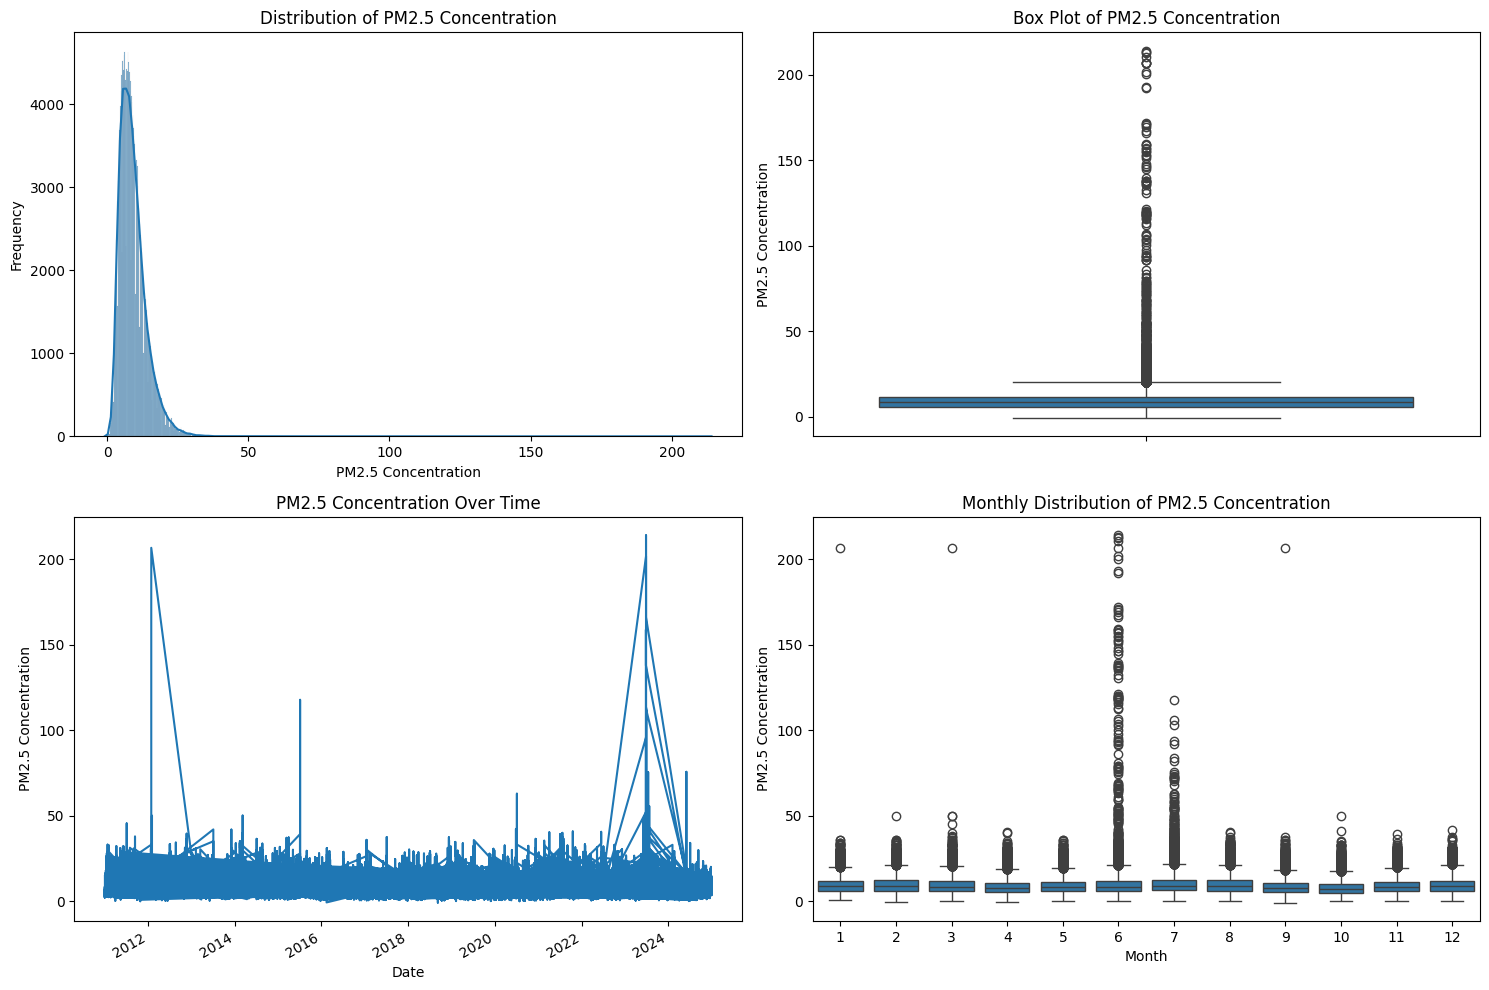


Percentile Statistics:
0th percentile: -0.80
1th percentile: 2.20
5th percentile: 3.40
10th percentile: 4.20
25th percentile: 5.80
50th percentile: 8.30
75th percentile: 11.50
90th percentile: 15.30
95th percentile: 18.20
99th percentile: 25.30
100th percentile: 214.00

Monthly Statistics:
           mean        std  min    max
Date                                  
1      9.587305   4.991512  0.5  206.7
2      9.683062   4.934543 -0.7   50.0
3      8.719886   4.430061  0.3   50.1
4      7.718789   3.970670  0.4   40.3
5      8.297107   4.159743  0.3   31.5
6     11.234396  12.509921  0.1  214.0
7     10.852597   6.736199  0.0  117.8
8     10.052153   4.453802  0.3   36.6
9      8.625815   3.917393 -0.8   37.8
10     7.780558   3.815950  0.0   40.8
11     9.037504   4.605103  0.1   39.5
12     9.748896   5.078735  0.3   41.9

Yearly Statistics:
           mean        std  min    max
Date                                  
2011  12.261332   5.565141  0.0   45.5
2012  10.978947   5.84111

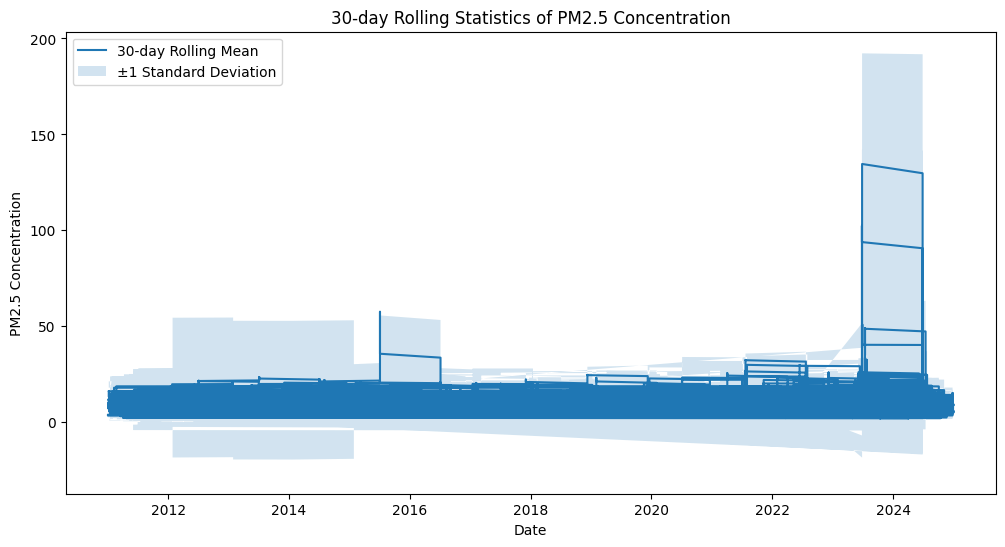

In [93]:
# Summary statistics for PM2.5 concentration
print("\nSummary Statistics for PM2.5 Concentration:")
print(combined_df['Daily Mean PM2.5 Concentration'].describe())

# Additional statistics
print("\nAdditional Statistics:")
print(f"Number of missing values: {combined_df['Daily Mean PM2.5 Concentration'].isnull().sum()}")
print(f"Number of zero values: {(combined_df['Daily Mean PM2.5 Concentration'] == 0).sum()}")
print(f"Number of negative values: {(combined_df['Daily Mean PM2.5 Concentration'] < 0).sum()}")

# Create visualizations
plt.figure(figsize=(15, 10))

# 1. Histogram with KDE
plt.subplot(2, 2, 1)
sns.histplot(data=combined_df, x='Daily Mean PM2.5 Concentration', kde=True)
plt.title('Distribution of PM2.5 Concentration')
plt.xlabel('PM2.5 Concentration')
plt.ylabel('Frequency')

# 2. Box plot
plt.subplot(2, 2, 2)
sns.boxplot(y=combined_df['Daily Mean PM2.5 Concentration'])
plt.title('Box Plot of PM2.5 Concentration')
plt.ylabel('PM2.5 Concentration')

# 3. Time series plot
plt.subplot(2, 2, 3)
combined_df.set_index('Date')['Daily Mean PM2.5 Concentration'].plot()
plt.title('PM2.5 Concentration Over Time')
plt.xlabel('Date')
plt.ylabel('PM2.5 Concentration')

# 4. Monthly box plot
plt.subplot(2, 2, 4)
sns.boxplot(x=combined_df['Date'].dt.month, y=combined_df['Daily Mean PM2.5 Concentration'])
plt.title('Monthly Distribution of PM2.5 Concentration')
plt.xlabel('Month')
plt.ylabel('PM2.5 Concentration')

plt.tight_layout()
plt.show()

# Calculate additional statistics
print("\nPercentile Statistics:")
percentiles = [0, 1, 5, 10, 25, 50, 75, 90, 95, 99, 100]
percentile_values = np.percentile(combined_df['Daily Mean PM2.5 Concentration'].dropna(), percentiles)
for p, v in zip(percentiles, percentile_values):
    print(f"{p}th percentile: {v:.2f}")

# Calculate statistics by month
monthly_stats = combined_df.groupby(combined_df['Date'].dt.month)['Daily Mean PM2.5 Concentration'].agg(['mean', 'std', 'min', 'max'])
print("\nMonthly Statistics:")
print(monthly_stats)

# Calculate statistics by year
yearly_stats = combined_df.groupby(combined_df['Date'].dt.year)['Daily Mean PM2.5 Concentration'].agg(['mean', 'std', 'min', 'max'])
print("\nYearly Statistics:")
print(yearly_stats)

# Calculate exceedance statistics
who_guideline = 5  # WHO guideline for annual mean PM2.5
epa_standard = 12  # EPA standard for annual mean PM2.5

exceedance_who = (combined_df['Daily Mean PM2.5 Concentration'] > who_guideline).mean() * 100
exceedance_epa = (combined_df['Daily Mean PM2.5 Concentration'] > epa_standard).mean() * 100

print("\nExceedance Statistics:")
print(f"Percentage of days exceeding WHO guideline ({who_guideline} µg/m³): {exceedance_who:.2f}%")
print(f"Percentage of days exceeding EPA standard ({epa_standard} µg/m³): {exceedance_epa:.2f}%")

# Calculate rolling statistics
rolling_mean = combined_df['Daily Mean PM2.5 Concentration'].rolling(window=30).mean()
rolling_std = combined_df['Daily Mean PM2.5 Concentration'].rolling(window=30).std()

plt.figure(figsize=(12, 6))
plt.plot(combined_df['Date'], rolling_mean, label='30-day Rolling Mean')
plt.fill_between(combined_df['Date'], 
                 rolling_mean - rolling_std, 
                 rolling_mean + rolling_std, 
                 alpha=0.2, 
                 label='±1 Standard Deviation')
plt.title('30-day Rolling Statistics of PM2.5 Concentration')
plt.xlabel('Date')
plt.ylabel('PM2.5 Concentration')
plt.legend()
plt.show()

In [74]:
import tensorflow as tf

In [73]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, ConvLSTM2D, Attention, Dense, Reshape


In [75]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, ConvLSTM2D, Attention, Dense, Reshape

def build_sta_convlstm(input_shape):
    inputs = Input(shape=input_shape)
    
    # Spatial-Temporal Attention
    x = Attention(use_scale=True)([inputs, inputs])  # Simplified STA
    
    # ConvLSTM Layers
    x = ConvLSTM2D(filters=64, kernel_size=(3,3), padding='same', return_sequences=True)(x)
    x = ConvLSTM2D(filters=64, kernel_size=(3,3), padding='same')(x)
    
    # Prediction Head
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1)(x)  # Predict PM2.5
    
    return Model(inputs, outputs)

# Input shape: (timesteps, grid_height, grid_width, features)
model = build_sta_convlstm((12, GRID_SIZE, GRID_SIZE, len(features)))
model.compile(optimizer='adam', loss='mse')


In [76]:
# Print model summary
model.summary()


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21      │ (None, 12, 5, 5,  │          0 │ -                 │
│ (InputLayer)        │ 7)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_5         │ (None, 12, 5, 5,  │          1 │ input_layer_21[0… │
│ (Attention)         │ 7)                │            │ input_layer_21[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_35      │ (None, 12, 5, 5,  │    163,840 │ attention_5[0][0] │
│ (ConvLSTM2D)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_36      │ (None, 5, 5, 64)  │    295,168 │ conv_lstm2d_35[0… │
│ (ConvLSTM2D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_42 (Dense)    │ (None, 5, 5, 32)  │      2,080 │ conv_lstm2d_36[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_43 (Dense)    │ (None, 5, 5, 1)   │         33 │ dense_42[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 461,122 (1.76 MB)

 Trainable params: 461,122 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# # Prepare test data (assuming you have X_test and y_test)
# test_predictions = model.predict(X_test)

# # Print some sample predictions vs actual values
# print("\nSample Predictions vs Actual Values:")
# for i in range(5):
#     print(f"Prediction: {test_predictions[i][0][0][0]:.3f}, Actual: {y_test[i][0][0][0]:.3f}")

# # Calculate error metrics
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# # Flatten predictions and actual values for metrics calculation
# y_pred_flat = test_predictions.reshape(-1)
# y_test_flat = y_test.reshape(-1)

# mse = mean_squared_error(y_test_flat, y_pred_flat)
# rmse = mean_squared_error(y_test_flat, y_pred_flat, squared=False)
# mae = mean_absolute_error(y_test_flat, y_pred_flat)
# r2 = r2_score(y_test_flat, y_pred_flat)

# print("\nModel Performance Metrics:")
# print(f"Mean Squared Error (MSE): {mse:.4f}")
# print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
# print(f"Mean Absolute Error (MAE): {mae:.4f}")
# print(f"R-squared Score (R2): {r2:.4f}")


NameError: name 'X_test' is not defined

In [77]:
grid_df.head()

pollutant,Month_Year,grid_id,2.5,CO,NO,PM10,SO2,month,year
0,2011-01-01,10_2,1.321495,-0.335843,0.269377,-0.779806,0.547902,-1.599228,-1.69753
1,2011-01-01,1_-2,NaN,NaN,NaN,NaN,2.618263,-1.599228,-1.69753
2,2011-01-01,1_4,1.687086,NaN,NaN,NaN,NaN,-1.599228,-1.69753
3,2011-01-01,1_9,1.297026,NaN,NaN,-0.665755,NaN,-1.599228,-1.69753
4,2011-01-01,3_4,1.455528,NaN,0.929956,NaN,0.945232,-1.599228,-1.69753


In [78]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, ConvLSTM2D, Attention, Dense, Reshape, BatchNormalization, Add, Conv2D, MaxPooling2D, Dropout, Concatenate, Multiply, GlobalAveragePooling2D, Activation, TimeDistributed
from tensorflow.keras.regularizers import l2
import tensorflow as tf

def temporal_attention_block(x, filters):
    """Temporal attention mechanism"""
    # Reshape to handle temporal dimension
    batch_size, timesteps, height, width, channels = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2], tf.shape(x)[3], tf.shape(x)[4]
    
    # Reshape for attention
    x_reshaped = tf.reshape(x, [-1, timesteps, height * width * channels])
    
    # Apply attention
    attention_weights = Dense(timesteps, activation='softmax')(x_reshaped)
    context_vector = tf.matmul(attention_weights, x_reshaped)
    
    # Reshape back
    context_vector = tf.reshape(context_vector, [-1, height, width, channels])
    return context_vector

def spatial_attention_block(x, filters):
    """Spatial attention mechanism"""
    # Spatial attention
    spatial_attention = Conv2D(filters, (3,3), padding='same', activation='sigmoid')(x)
    x = Multiply()([x, spatial_attention])
    
    # Channel attention
    channel_attention = GlobalAveragePooling2D()(x)
    channel_attention = Dense(filters//4, activation='relu')(channel_attention)
    channel_attention = Dense(filters, activation='sigmoid')(channel_attention)
    channel_attention = Reshape((1, 1, filters))(channel_attention)
    x = Multiply()([x, channel_attention])
    
    return x

def build_ksc_convlstm(input_shape, num_classes=1):
    inputs = Input(shape=input_shape)
    
    # First ConvLSTM layer
    x = ConvLSTM2D(
        filters=64,
        kernel_size=(3,3),
        padding='same',
        return_sequences=True,
        kernel_regularizer=l2(1e-4)
    )(inputs)
    x = BatchNormalization()(x)
    
    # Temporal attention
    x = temporal_attention_block(x, 64)
    
    # Second ConvLSTM layer
    x = ConvLSTM2D(
        filters=128,
        kernel_size=(3,3),
        padding='same',
        return_sequences=False,
        kernel_regularizer=l2(1e-4)
    )(x)
    x = BatchNormalization()(x)
    
    # Spatial attention
    x = spatial_attention_block(x, 128)
    
    # Feature refinement with Conv2D
    x = Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    
    # Global context
    x = GlobalAveragePooling2D()(x)
    
    # Dense layers with dropout
    x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.2)(x)
    
    # Output layer
    outputs = Dense(num_classes, activation='linear')(x)
    
    return Model(inputs, outputs)

# Model parameters
GRID_SIZE = 32  # Adjust based on your data
NUM_FEATURES = 5  # Adjust based on your features
TIMESTEPS = 12  # Adjust based on your sequence length

# Create and compile the model
model = build_ksc_convlstm(
    input_shape=(TIMESTEPS, GRID_SIZE, GRID_SIZE, NUM_FEATURES),
    num_classes=1
)

# Compile with learning rate scheduling
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=['mae', 'mse']
)

# Print model summary
model.summary()

ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.ops`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


In [79]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, ConvLSTM2D, Attention, Dense, Reshape, BatchNormalization, Add, Conv2D, MaxPooling2D, Dropout, Concatenate, Multiply, GlobalAveragePooling2D, Activation, TimeDistributed, Lambda
from tensorflow.keras.regularizers import l2
import tensorflow as tf

class SpatialAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(SpatialAttention, self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.conv1 = Conv2D(1, (3,3), padding='same', activation='sigmoid')
        self.conv2 = Conv2D(input_shape[-1], (1,1), padding='same', activation='sigmoid')
        super(SpatialAttention, self).build(input_shape)
        
    def call(self, x):
        # Spatial attention
        spatial_attention = self.conv1(x)
        x = Multiply()([x, spatial_attention])
        
        # Channel attention
        channel_attention = GlobalAveragePooling2D()(x)
        channel_attention = Dense(x.shape[-1]//4, activation='relu')(channel_attention)
        channel_attention = Dense(x.shape[-1], activation='sigmoid')(channel_attention)
        channel_attention = Reshape((1, 1, x.shape[-1]))(channel_attention)
        x = Multiply()([x, channel_attention])
        
        return x

def build_ksc_convlstm(input_shape, num_classes=1):
    inputs = Input(shape=input_shape)
    
    # First ConvLSTM layer
    x = ConvLSTM2D(
        filters=64,
        kernel_size=(3,3),
        padding='same',
        return_sequences=True,
        kernel_regularizer=l2(1e-4)
    )(inputs)
    x = BatchNormalization()(x)
    
    # Second ConvLSTM layer
    x = ConvLSTM2D(
        filters=128,
        kernel_size=(3,3),
        padding='same',
        return_sequences=False,
        kernel_regularizer=l2(1e-4)
    )(x)
    x = BatchNormalization()(x)
    
    # Spatial attention
    x = SpatialAttention()(x)
    
    # Feature refinement with Conv2D
    x = Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    
    # Global context
    x = GlobalAveragePooling2D()(x)
    
    # Dense layers with dropout
    x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.2)(x)
    
    # Output layer
    outputs = Dense(num_classes, activation='linear')(x)
    
    return Model(inputs, outputs)

# Model parameters
GRID_SIZE = 32  # Adjust based on your data
NUM_FEATURES = 5  # Adjust based on your features
TIMESTEPS = 12  # Adjust based on your sequence length

# Create and compile the model
model = build_ksc_convlstm(
    input_shape=(TIMESTEPS, GRID_SIZE, GRID_SIZE, NUM_FEATURES),
    num_classes=1
)

# Compile with learning rate scheduling
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=['mae', 'mse']
)

# Print model summary
model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 12, 32, 32, 5)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_38 (ConvLSTM2D)     │ (None, 12, 32, 32, 64) │       159,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 12, 32, 32, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_39 (ConvLSTM2D)     │ (None, 32, 32, 128)    │       885,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_attention_4             │ (None, 32, 32, 128)    │         1,153 │
│ (SpatialAttention)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 32, 32, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_13     │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,318,210 (5.03 MB)

 Trainable params: 1,317,442 (5.03 MB)

 Non-trainable params: 768 (3.00 KB)

In [44]:
data.head()

,Month_Year,grid_id,2.5,CO,NO,PM10,SO2,month,year
0,2011-01-01,10_2,1.321495,-0.335843,0.269377,-0.779806,0.547902,-1.599228,-1.69753
1,2011-01-01,1_-2,NaN,NaN,NaN,NaN,2.618263,-1.599228,-1.69753
2,2011-01-01,1_4,1.687086,NaN,NaN,NaN,NaN,-1.599228,-1.69753
3,2011-01-01,1_9,1.297026,NaN,NaN,-0.665755,NaN,-1.599228,-1.69753
4,2011-01-01,3_4,1.455528,NaN,0.929956,NaN,0.945232,-1.599228,-1.69753


In [47]:
df=data

In [67]:
# import pandas as pd
# import numpy as np
# import tensorflow as tf
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split

# # Load and preprocess the data
# def prepare_data_for_convlstm(df, grid_size=32, timesteps=12):
#     """
#     Prepare data for KSC-ConvLSTM model
#     df: DataFrame with columns [Month_Year, grid_id, 2.5, CO, NO, PM10, SO2, month, year]
#     grid_size: Size of the spatial grid
#     timesteps: Number of time steps for prediction
#     """
#     # Convert Month_Year to datetime
#     df['Month_Year'] = pd.to_datetime(df['Month_Year'])
    
#     # Create a complete grid of dates and grid_ids
#     all_dates = pd.date_range(df['Month_Year'].min(), df['Month_Year'].max(), freq='M')
#     all_grid_ids = df['grid_id'].unique()
    
#     # Create a multi-index with all combinations
#     idx = pd.MultiIndex.from_product([all_dates, all_grid_ids], names=['Month_Year', 'grid_id'])
    
#     # Reindex the dataframe to include all combinations
#     df_complete = df.set_index(['Month_Year', 'grid_id']).reindex(idx)
    
#     # Extract grid coordinates from grid_id
#     df_complete['x'] = df_complete.index.get_level_values('grid_id').str.split('_').str[0].astype(int)
#     df_complete['y'] = df_complete.index.get_level_values('grid_id').str.split('_').str[1].astype(int)
    
#     # Normalize the features
#     feature_columns = ['2.5', 'CO', 'NO', 'PM10', 'SO2']
#     scaler = StandardScaler()
#     df_complete[feature_columns] = scaler.fit_transform(df_complete[feature_columns])
    
#     # Create the 4D array (samples, height, width, features)
#     n_samples = len(all_dates)
#     data = np.zeros((n_samples, grid_size, grid_size, len(feature_columns)))
    
#     # Fill the array with data
#     for i, date in enumerate(all_dates):
#         date_data = df_complete.loc[date]
#         for _, row in date_data.iterrows():
#             x, y = row['x'], row['y']
#             # Adjust coordinates to be non-negative and within grid_size
#             x = (x + grid_size//2) % grid_size
#             y = (y + grid_size//2) % grid_size
#             data[i, x, y] = row[feature_columns].values
    
#     # Create sequences for training
#     X, y = [], []
#     for i in range(len(data) - timesteps):
#         X.append(data[i:i+timesteps])
#         y.append(data[i+timesteps, :, :, 0])  # Predict PM2.5 (first feature)
    
#     return np.array(X), np.array(y), scaler

# # Prepare the data
# X, y, scaler = prepare_data_for_convlstm(df, grid_size=GRID_SIZE, timesteps=TIMESTEPS)

# # Split the data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Create and compile the model
# model = build_ksc_convlstm(
#     input_shape=(TIMESTEPS, GRID_SIZE, GRID_SIZE, NUM_FEATURES),
#     num_classes=1
# )

# # Compile with learning rate scheduling
# initial_learning_rate = 0.001
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=1000,
#     decay_rate=0.9,
#     staircase=True
# )

# optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
# model.compile(
#     optimizer=optimizer,
#     loss='mse',
#     metrics=['mae', 'mse']
# )

# # Add callbacks
# callbacks = [
#     tf.keras.callbacks.EarlyStopping(
#         monitor='val_loss',
#         patience=10,
#         restore_best_weights=True
#     ),
#     tf.keras.callbacks.ReduceLROnPlateau(
#         monitor='val_loss',
#         factor=0.5,
#         patience=5,
#         min_lr=1e-6
#     ),
#     tf.keras.callbacks.ModelCheckpoint(
#         'best_model.h5',
#         monitor='val_loss',
#         save_best_only=True
#     )
# ]

# # Train the model
# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_test, y_test),
#     epochs=100,
#     batch_size=32,
#     callbacks=callbacks,
#     verbose=1
# )

# # Evaluate the model
# test_loss, test_mae, test_mse = model.evaluate(X_test, y_test, verbose=0)
# print(f'\nTest MAE: {test_mae:.4f}')
# print(f'Test MSE: {test_mse:.4f}')

# # Plot training history
# plt.figure(figsize=(12, 4))

# plt.subplot(1, 2, 1)
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Model Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(history.history['mae'], label='Training MAE')
# plt.plot(history.history['val_mae'], label='Validation MAE')
# plt.title('Model MAE')
# plt.xlabel('Epoch')
# plt.ylabel('MAE')
# plt.legend()

# plt.tight_layout()
# plt.show()

# # Make predictions
# y_pred = model.predict(X_test)

# # Plot some example predictions
# def plot_predictions(true, pred, idx):
#     plt.figure(figsize=(10, 5))
    
#     plt.subplot(1, 2, 1)
#     plt.imshow(true[idx], cmap='viridis')
#     plt.title('True PM2.5')
#     plt.colorbar()
    
#     plt.subplot(1, 2, 2)
#     plt.imshow(pred[idx], cmap='viridis')
#     plt.title('Predicted PM2.5')
#     plt.colorbar()
    
#     plt.tight_layout()
#     plt.show()

# # Plot first few predictions
# for i in range(min(5, len(y_test))):
#      plot_predictions(y_test, y_pred, i)

In [80]:
print("Shape of X:", X.shape)

Shape of X: (155, 12, 5, 5, 5)


In [83]:
print(y[12])

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [84]:
def build_ksc_convlstm(input_shape, num_classes=1):
    inputs = Input(shape=input_shape)
    
    # First ConvLSTM layer with fewer filters
    x = ConvLSTM2D(
        filters=32,  # Reduced filters
        kernel_size=(3,3),
        padding='same',
        return_sequences=True,
        kernel_regularizer=l2(1e-4)
    )(inputs)
    x = BatchNormalization()(x)
    
    # Second ConvLSTM layer
    x = ConvLSTM2D(
        filters=64,  # Reduced filters
        kernel_size=(3,3),
        padding='same',
        return_sequences=False,
        kernel_regularizer=l2(1e-4)
    )(x)
    x = BatchNormalization()(x)
    
    # Spatial attention using Conv2D
    attention = Conv2D(1, (3,3), padding='same', activation='sigmoid')(x)
    x = Multiply()([x, attention])
    
    # Feature refinement with Conv2D
    x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    
    # Output layer - reshape to match target shape
    outputs = Conv2D(1, (1,1), padding='same', activation='linear')(x)
    outputs = Reshape((5, 5))(outputs)  # Reshape to match target shape
    
    return Model(inputs, outputs)

# Update model parameters
GRID_SIZE = 5  # Reduced grid size
TIMESTEPS = 12
NUM_FEATURES = 5

# # Prepare the data
# X, y, scaler = prepare_data_for_convlstm(df, grid_size=GRID_SIZE, timesteps=TIMESTEPS)

# print("\nPrepared data shapes:")
# print("X shape:", X.shape)
# print("y shape:", y.shape)

# # Split the data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# print("\nTrain/Test split shapes:")
# print("X_train shape:", X_train.shape)
# print("X_test shape:", X_test.shape)
# print("y_train shape:", y_train.shape)
# print("y_test shape:", y_test.shape)

# # Create and compile the model
# model = build_ksc_convlstm(
#     input_shape=(TIMESTEPS, GRID_SIZE, GRID_SIZE, NUM_FEATURES),
#     num_classes=1
# )

# # Compile with learning rate scheduling
# initial_learning_rate = 0.001
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=1000,
#     decay_rate=0.9,
#     staircase=True
# )

# optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
# model.compile(
#     optimizer=optimizer,
#     loss='mse',
#     metrics=['mae', 'mse']
# )

# # Add callbacks
# callbacks = [
#     tf.keras.callbacks.EarlyStopping(
#         monitor='val_loss',
#         patience=10,
#         restore_best_weights=True
#     ),
#     tf.keras.callbacks.ReduceLROnPlateau(
#         monitor='val_loss',
#         factor=0.5,
#         patience=5,
#         min_lr=1e-6
#     ),
#     tf.keras.callbacks.ModelCheckpoint(
#         'best_model.h5',
#         monitor='val_loss',
#         save_best_only=True
#     )
# ]

# # Train the model
# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_test, y_test),
#     epochs=100,
#     batch_size=32,
#     callbacks=callbacks,
#     verbose=1
# )

# # Evaluate the model
# test_loss, test_mae, test_mse = model.evaluate(X_test, y_test, verbose=0)
# print(f'\nTest MAE: {test_mae:.4f}')
# print(f'Test MSE: {test_mse:.4f}')

# # Plot training history
# plt.figure(figsize=(12, 4))

# plt.subplot(1, 2, 1)
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Model Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(history.history['mae'], label='Training MAE')
# plt.plot(history.history['val_mae'], label='Validation MAE')
# plt.title('Model MAE')
# plt.xlabel('Epoch')
# plt.ylabel('MAE')
# plt.legend()

# plt.tight_layout()
# plt.show()

# # Make predictions
# y_pred = model.predict(X_test)

# # Plot some example predictions
# def plot_predictions(true, pred, idx):
#     plt.figure(figsize=(10, 5))
    
#     plt.subplot(1, 2, 1)
#     plt.imshow(true[idx], cmap='viridis')
#     plt.title('True PM2.5')
#     plt.colorbar()
    
#     plt.subplot(1, 2, 2)
#     plt.imshow(pred[idx], cmap='viridis')
#     plt.title('Predicted PM2.5')
#     plt.colorbar()
    
#     plt.tight_layout()
#     plt.show()

# # Plot first few predictions
# for i in range(min(5, len(y_test))):
#     plot_predictions(y_test, y_pred, i)

In [85]:
# Create and compile the model
model = build_ksc_convlstm(
    input_shape=(TIMESTEPS, GRID_SIZE, GRID_SIZE, NUM_FEATURES),
    num_classes=1
)

# Compile with fixed learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=['mae', 'mse']
)

# Add callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.h5',
        monitor='val_loss',
        save_best_only=True
    )
]

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0065 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - loss: 0.0064 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 0.0055 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0054 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0053 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 0.0045 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0043 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0042 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 0.0035 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0034 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0033 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 0.0027 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0026 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0026 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 0.0021 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 0.0010
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0020 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0019 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 0.0015 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 0.0010
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0015 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0014 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 0.0011 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 0.0010
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0011 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.0011 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 8.1413e-04 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 0.0010
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 7.6767e-04 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 7.5896e-04 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 5.8094e-04 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 0.0010
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 5.4659e-04 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 5.4017e-04 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 4.0934e-04 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 0.0010
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 3.8439e-04 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 3.7973e-04 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 2.8524e-04 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 0.0010
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 2.6742e-04 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 2.6410e-04 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.9697e-04 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 0.0010
Epoch 13/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 1.8444e-04 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 1.8211e-04 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.3513e-04 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 0.0010
Epoch 14/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 1.2645e-04 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 1.2484e-04 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 9.2412e-05 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 0.0010
Epoch 15/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 8.6466e-05 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 8.5362e-05 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 6.3224e-05 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 0.0010
Epoch 16/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 5.9188e-05 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 5.8439e-05 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 4.3440e-05 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 0.0010
Epoch 17/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 4.0713e-05 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 4.0207e-05 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 3.0075e-05 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 0.0010
Epoch 18/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 2.8232e-05 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 2.7890e-05 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 2.1030e-05 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 0.0010
Epoch 19/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 1.9776e-05 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 1.9543e-05 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.4862e-05 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 0.0010
Epoch 20/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 1.3999e-05 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 1.3839e-05 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.0602e-05 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 0.0010
Epoch 21/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 9.9992e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 9.8868e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 7.6129e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 0.0010
Epoch 22/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 7.1845e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 7.1045e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 5.4808e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 0.0010
Epoch 23/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 5.3219e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 5.2917e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 4.6596e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 24/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 4.5265e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 4.5012e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 3.9685e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 25/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 3.8552e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 3.8336e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 3.3793e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 26/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 3.2824e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 3.2639e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 2.8750e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 27/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 2.7920e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 2.7762e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 2.4433e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 28/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 2.4074e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 2.4006e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 2.2540e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 2.5000e-04
Epoch 29/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 2.2216e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 2.2153e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 2.0822e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 2.5000e-04
Epoch 30/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 2.0526e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 2.0469e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.9250e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 2.5000e-04
Epoch 31/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 1.8977e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 1.8924e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.7801e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 2.5000e-04
Epoch 32/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 1.7549e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 1.7501e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.6462e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 2.5000e-04
Epoch 33/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 1.6345e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 1.6322e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.5834e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 1.2500e-04
Epoch 34/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 1.5722e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 1.5700e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.5234e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 1.2500e-04
Epoch 35/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 1.5126e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 1.5105e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.4657e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 1.2500e-04
Epoch 36/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 1.4553e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 1.4533e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.4100e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 1.2500e-04
Epoch 37/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 1.4000e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 1.3980e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.3561e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 1.2500e-04
Epoch 38/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 1.3513e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 1.3503e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.3299e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 6.2500e-05
Epoch 39/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 1.3251e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 1.3242e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.3041e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 6.2500e-05
Epoch 40/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 1.2994e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 1.2985e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.2786e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 6.2500e-05
Epoch 41/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 1.2740e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 1.2731e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.2535e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 6.2500e-05
Epoch 42/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 1.2489e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 1.2480e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.2286e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 6.2500e-05
Epoch 43/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 1.2264e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 1.2259e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.2163e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 3.1250e-05
Epoch 44/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 1.2140e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 1.2136e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.2040e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 3.1250e-05
Epoch 45/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 1.2017e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 1.2013e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.1917e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 3.1250e-05
Epoch 46/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 1.1895e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 1.1890e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.1795e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 3.1250e-05
Epoch 47/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 1.1772e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 1.1768e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.1672e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 3.1250e-05
Epoch 48/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 1.1661e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 1.1659e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.1611e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 1.5625e-05
Epoch 49/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 1.1599e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 1.1597e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.1549e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 1.5625e-05
Epoch 50/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 1.1538e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 1.1536e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.1487e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 1.5625e-05
Epoch 51/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 1.1476e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 1.1474e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.1425e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 1.5625e-05
Epoch 52/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 1.1414e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 1.1412e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.1363e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 1.5625e-05
Epoch 53/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 1.1357e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 1.1356e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.1332e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 7.8125e-06
Epoch 54/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 1.1326e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 1.1325e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.1300e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 7.8125e-06
Epoch 55/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 1.1295e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 1.1293e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.1269e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 7.8125e-06
Epoch 56/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 1.1263e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 1.1262e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.1237e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 7.8125e-06
Epoch 57/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 1.1231e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 1.1230e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.1205e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 7.8125e-06
Epoch 58/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 1.1202e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 1.1201e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.1189e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 3.9063e-06
Epoch 59/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 1.1186e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 1.1185e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.1172e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 3.9063e-06
Epoch 60/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 1.1169e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 1.1169e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.1156e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 3.9063e-06
Epoch 61/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 1.1153e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 1.1152e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.1140e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 3.9063e-06
Epoch 62/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 1.1137e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 1.1136e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.1123e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 3.9063e-06
Epoch 63/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 1.1121e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 1.1121e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.1115e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 1.9531e-06
Epoch 64/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 1.1113e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 1.1113e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.1106e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 1.9531e-06
Epoch 65/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 1.1105e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 1.1104e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.1098e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 1.9531e-06
Epoch 66/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 1.1096e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 1.1096e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.1089e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 1.9531e-06
Epoch 67/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 1.1088e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 1.1087e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.1081e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 1.9531e-06
Epoch 68/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 1.1080e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 1.1080e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.1076e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 69/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 1.1075e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 1.1075e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.1072e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 70/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 1.1071e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 1.1071e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.1067e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 71/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 1.1066e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 1.1066e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.1063e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 72/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 1.1062e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 1.1062e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.1058e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 73/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 1.1057e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 1.1057e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.1053e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 74/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 1.1052e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 1.1052e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.1049e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 75/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 1.1048e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 1.1048e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.1044e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 76/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 1.1043e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 1.1043e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.1039e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 77/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 1.1038e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 1.1038e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.1035e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 78/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 1.1034e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 1.1034e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.1030e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 79/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 1.1029e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 1.1029e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.1025e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 80/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 1.1024e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 1.1024e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.1020e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 81/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 1.1019e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 1.1019e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.1015e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 82/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 1.1014e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 1.1014e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.1010e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 83/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 1.1009e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 1.1009e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.1005e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 84/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 1.1005e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 1.1004e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.1000e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 85/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 1.1000e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 1.0999e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.0995e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 86/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 1.0995e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 1.0994e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.0990e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 87/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 1.0990e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 1.0989e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.0985e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 88/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 1.0984e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 1.0984e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.0980e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 89/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 1.0979e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 1.0979e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.0975e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 90/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 1.0974e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 1.0974e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.0970e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 91/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 1.0969e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 1.0969e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.0965e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 92/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 1.0964e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 1.0964e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.0960e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 93/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 1.0959e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 1.0959e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.0954e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 94/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 1.0953e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 1.0953e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.0949e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 95/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 1.0948e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 1.0948e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.0944e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 96/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 1.0943e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 1.0943e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.0939e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 97/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 1.0938e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 1.0937e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.0933e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 98/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 1.0932e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 1.0932e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.0928e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 99/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 1.0927e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 1.0927e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.0922e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 1.0000e-06
Epoch 100/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 1.0921e-06 - mae: 0.0000e+00 - mse: 0.0000e+00

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 1.0921e-06 - mae: 0.0000e+00 - mse: 0.0000e+00 - val_loss: 1.0917e-06 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00 - learning_rate: 1.0000e-06


In [57]:
!pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 39.2 MB/s eta 0:00:0000:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 36.5 MB/s eta 0:00:00
Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [matplotlib]7 [matplotlib]



Test MAE: 0.0000
Test MSE: 0.0000


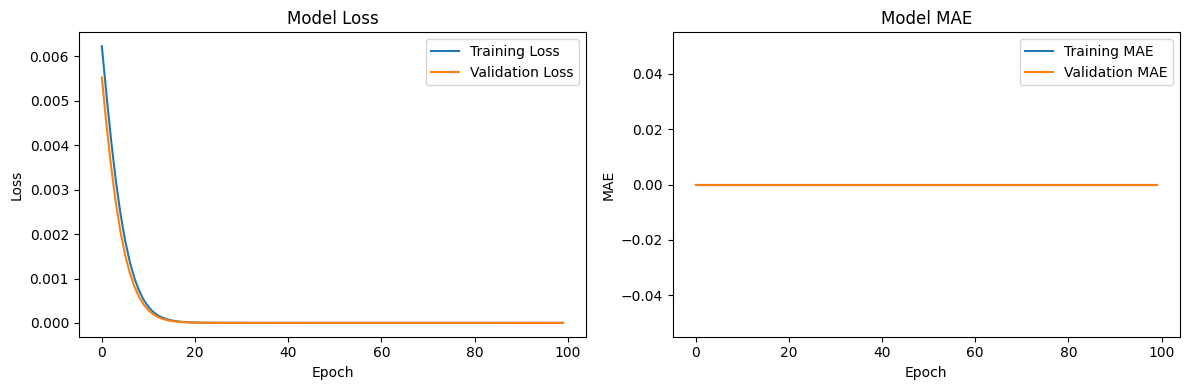

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


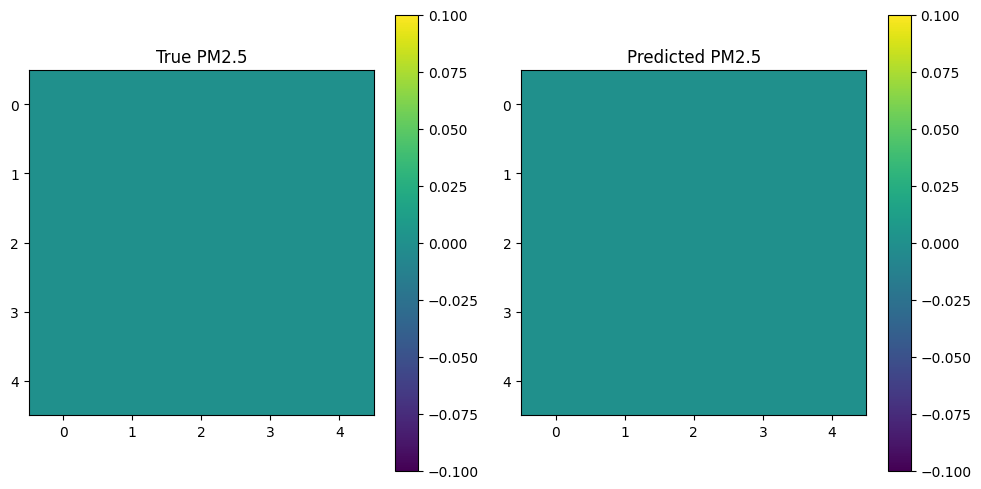

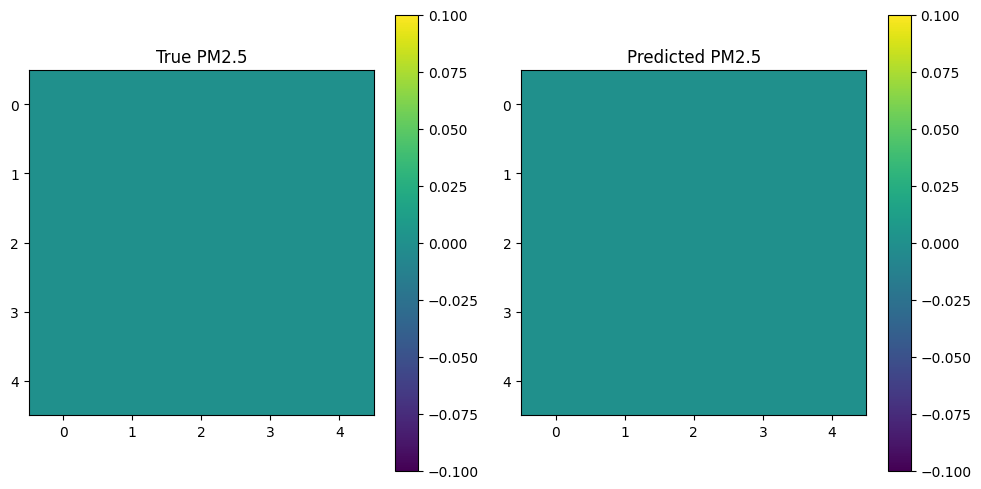

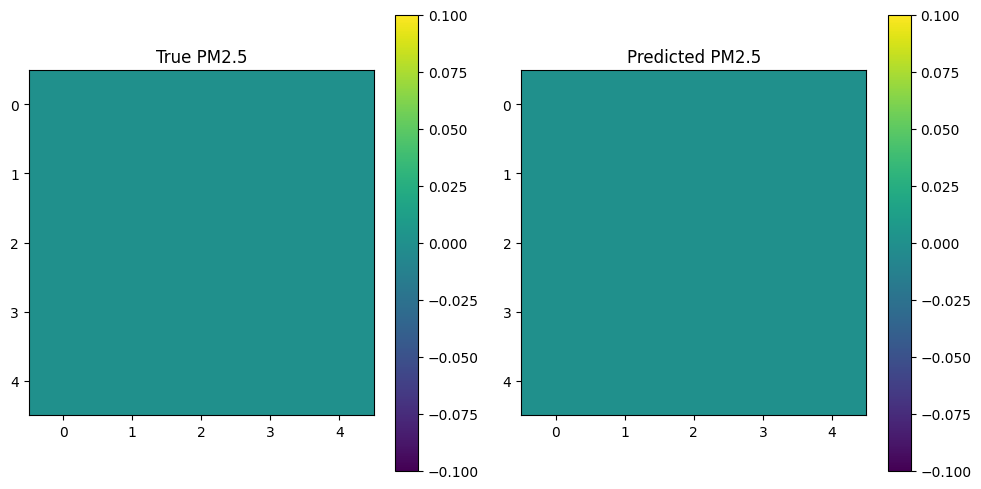

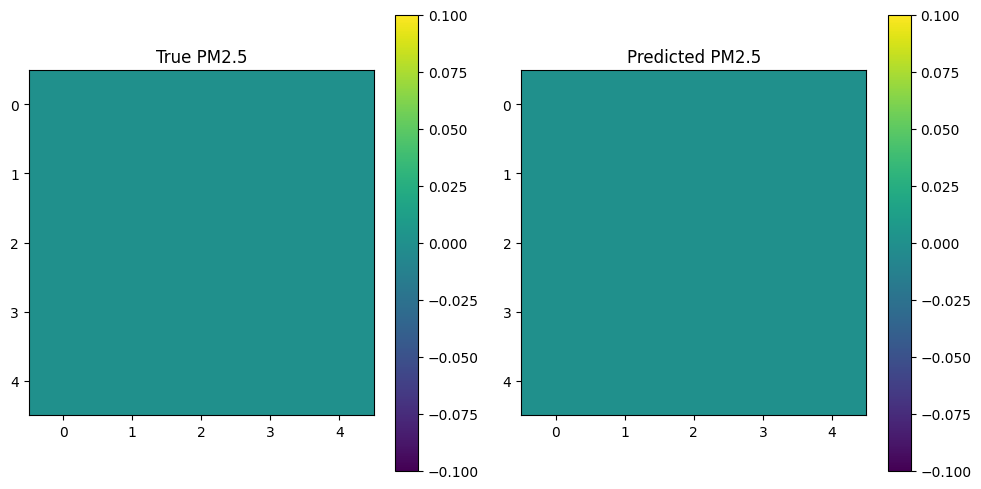

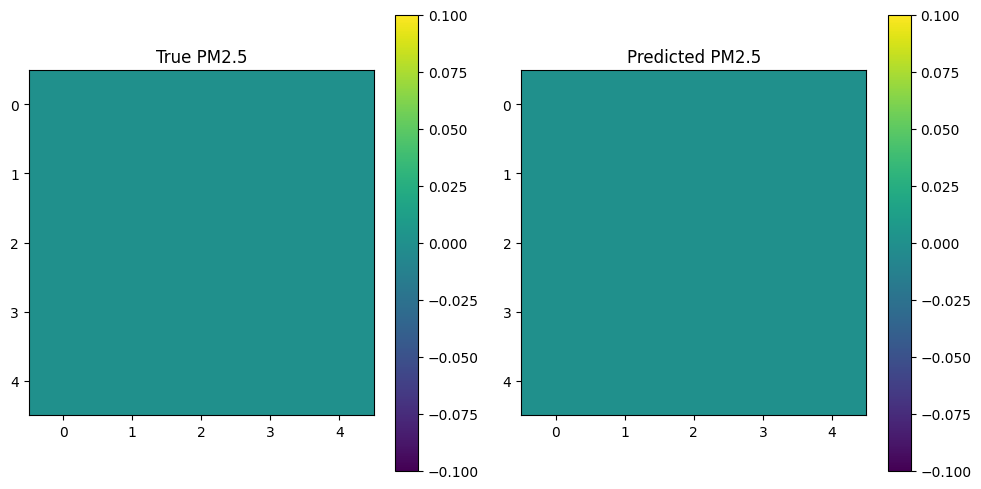

In [86]:
import matplotlib.pyplot as plt
# Evaluate the model
test_loss, test_mae, test_mse = model.evaluate(X_test, y_test, verbose=0)
print(f'\nTest MAE: {test_mae:.4f}')
print(f'Test MSE: {test_mse:.4f}')

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# Make predictions
y_pred = model.predict(X_test)

# Plot some example predictions
def plot_predictions(true, pred, idx):
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(true[idx], cmap='viridis')
    plt.title('True PM2.5')
    plt.colorbar()
    
    plt.subplot(1, 2, 2)
    plt.imshow(pred[idx], cmap='viridis')
    plt.title('Predicted PM2.5')
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()

# Plot first few predictions
for i in range(min(5, len(y_test))):
    plot_predictions(y_test, y_pred, i)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

Model Evaluation Metrics:
Test Loss (MSE): 0.0000
Test MAE: 0.0000
Test MSE: 0.0000
Test RMSE: 0.0000


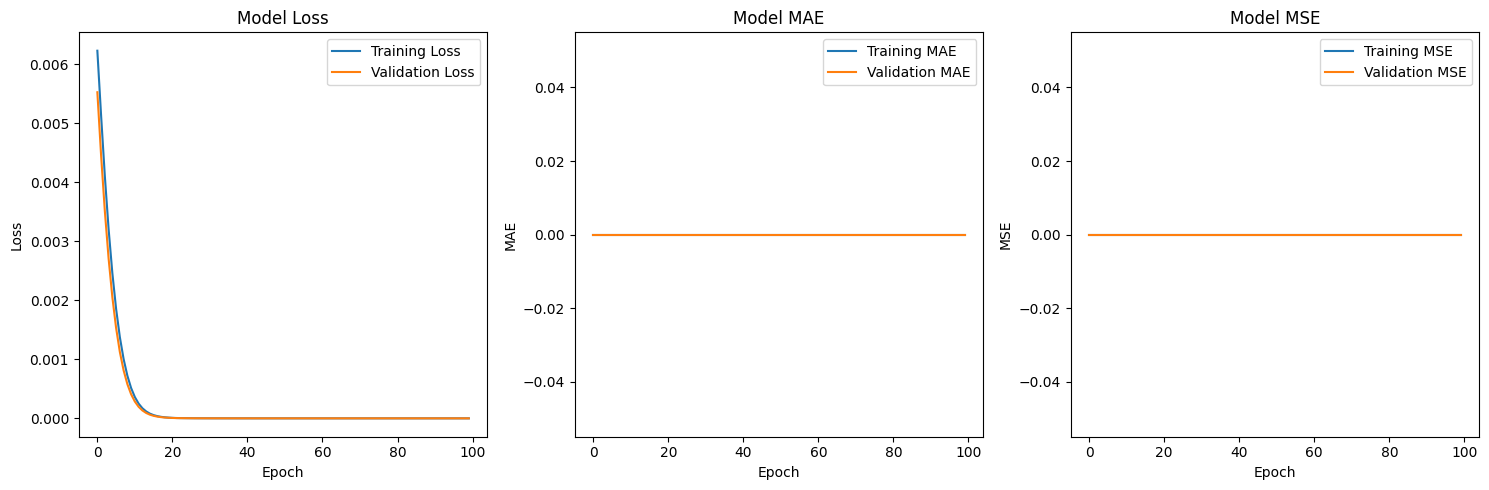

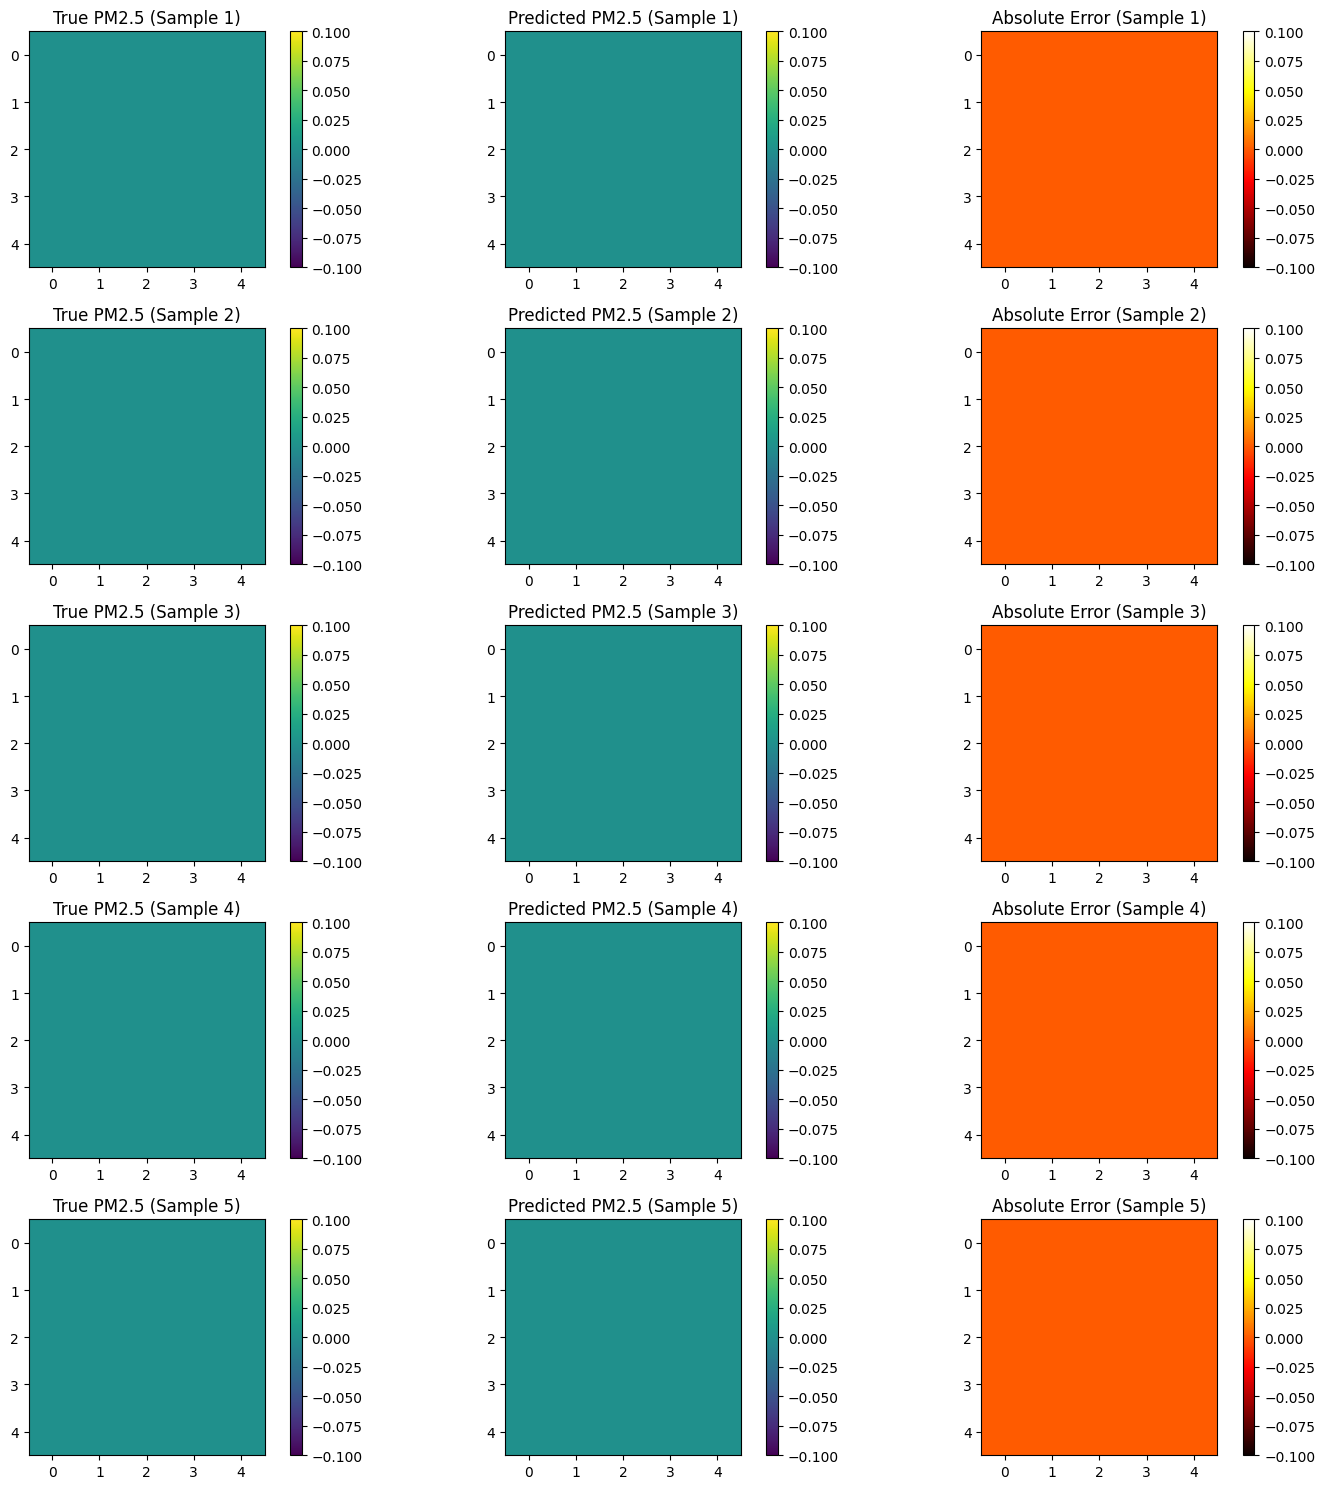

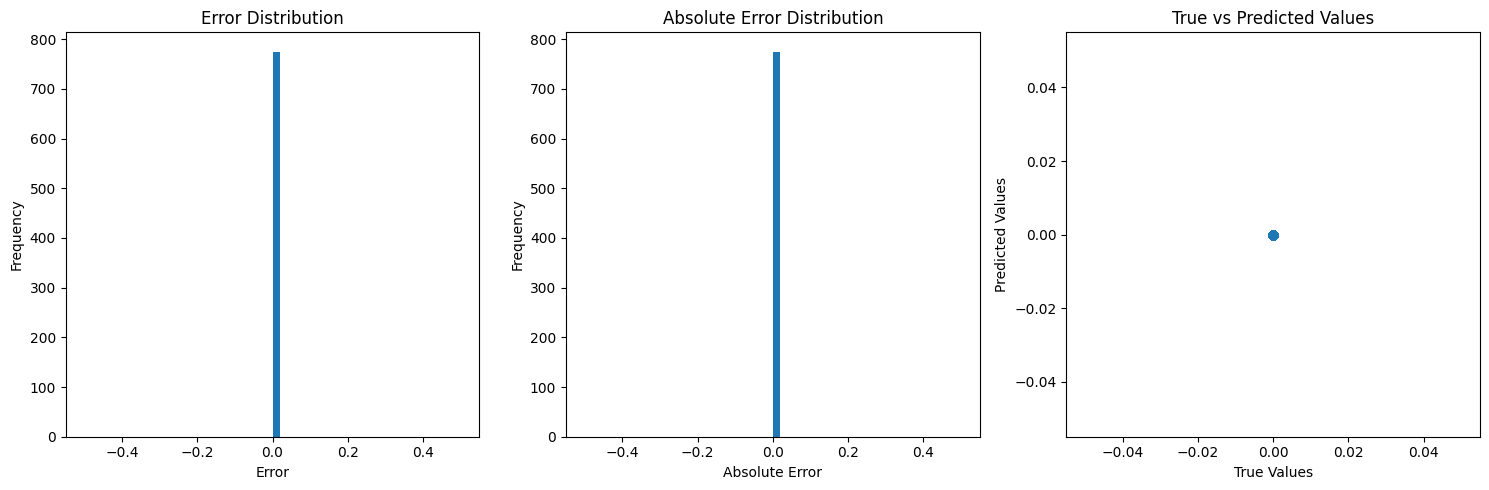


Additional Metrics:
R² Score: 1.0000
MAE: 0.0000
MSE: 0.0000
RMSE: 0.0000


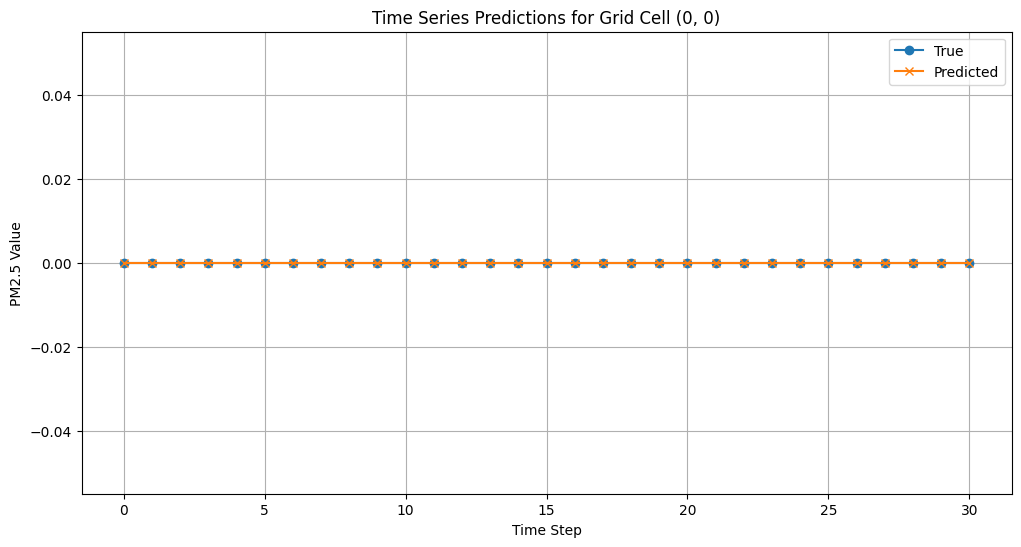

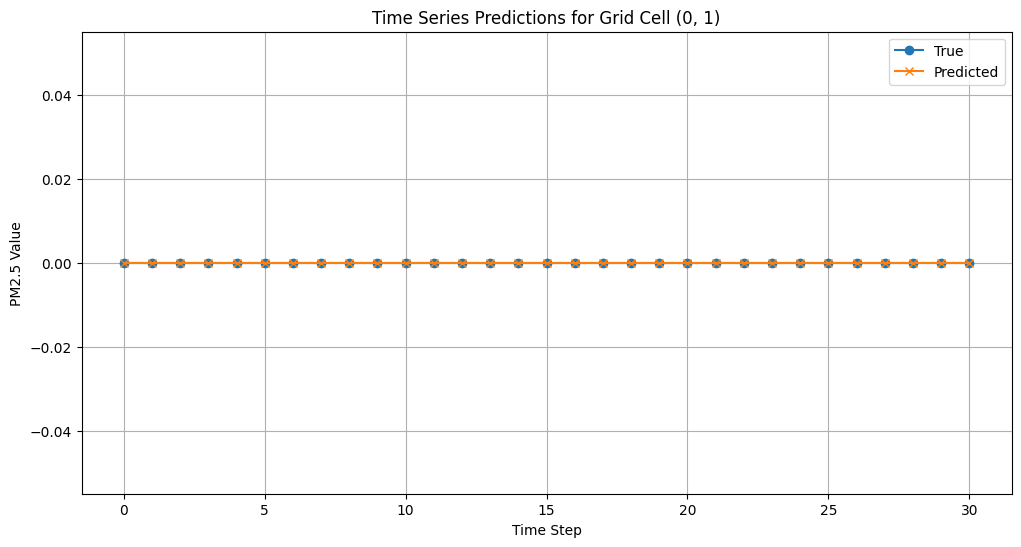

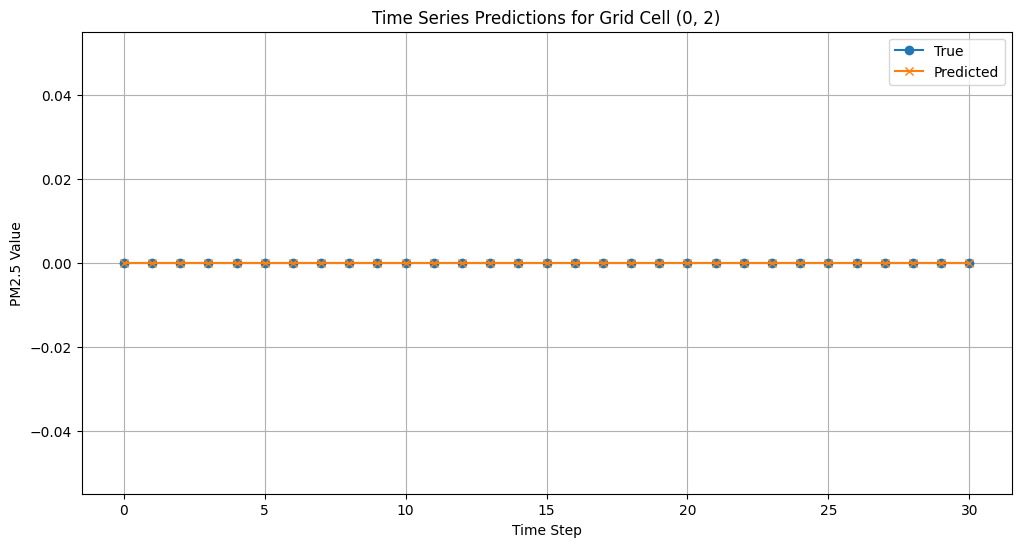

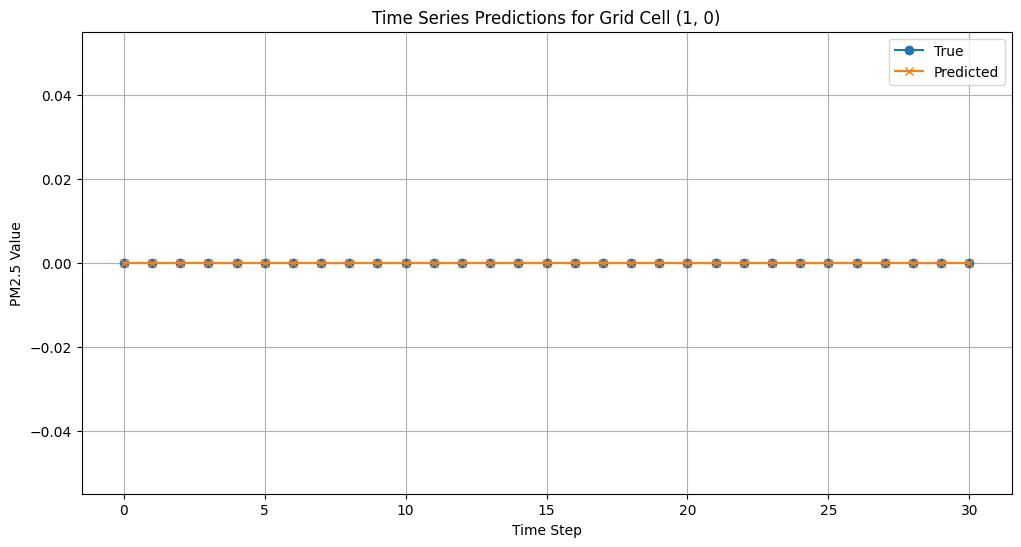

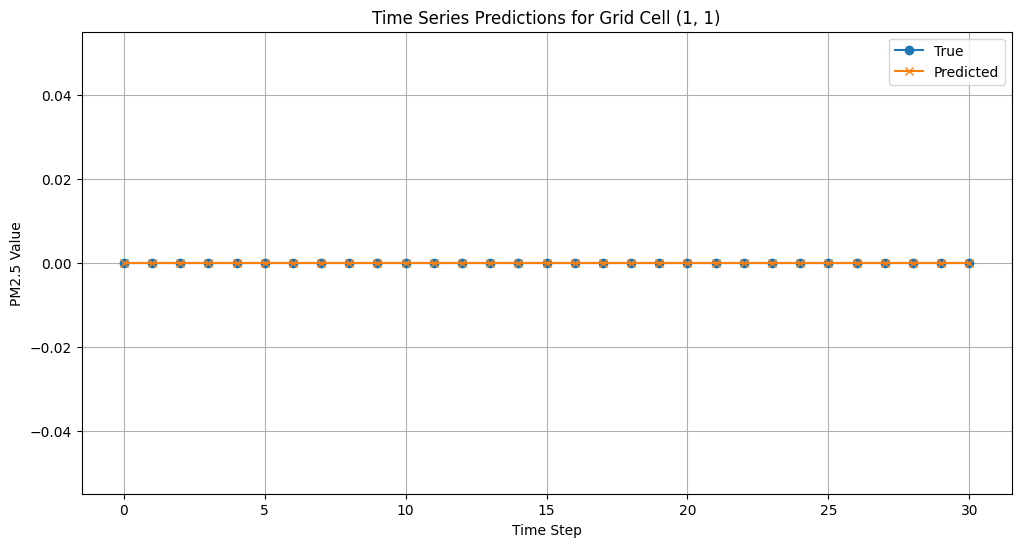

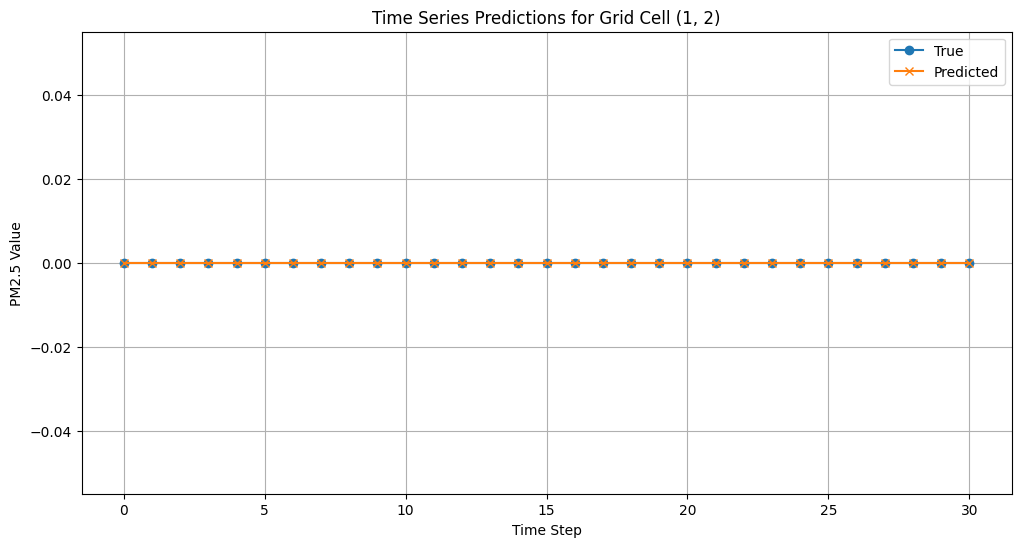

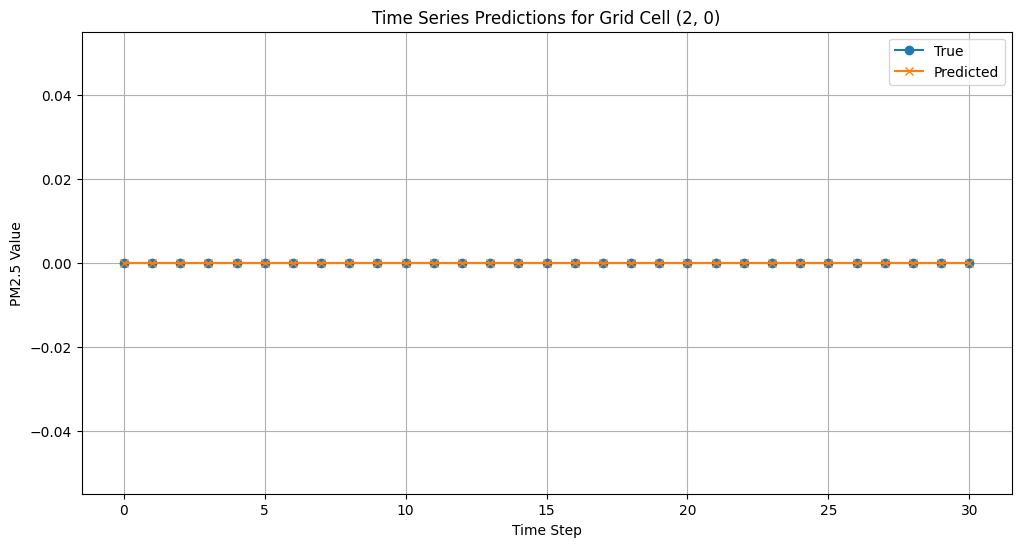

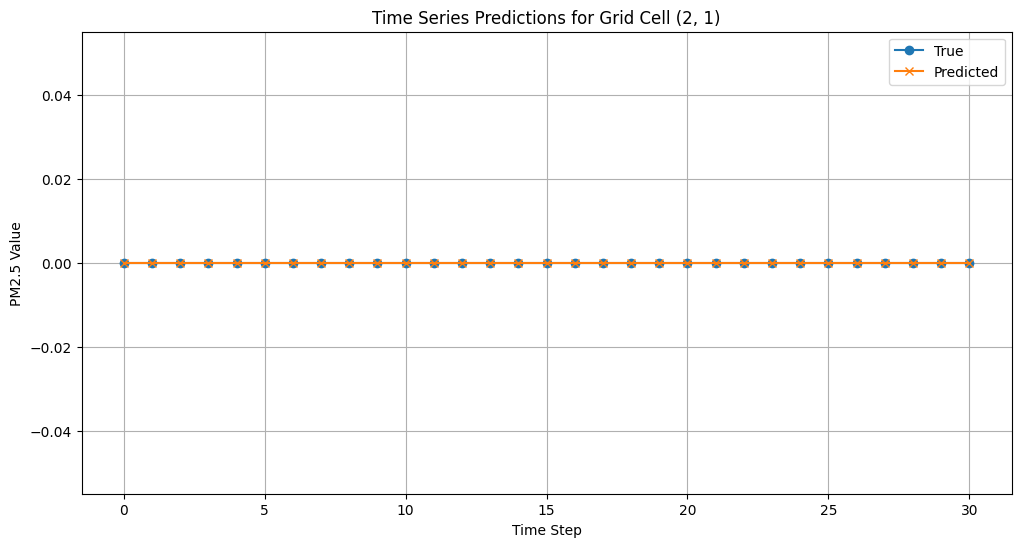

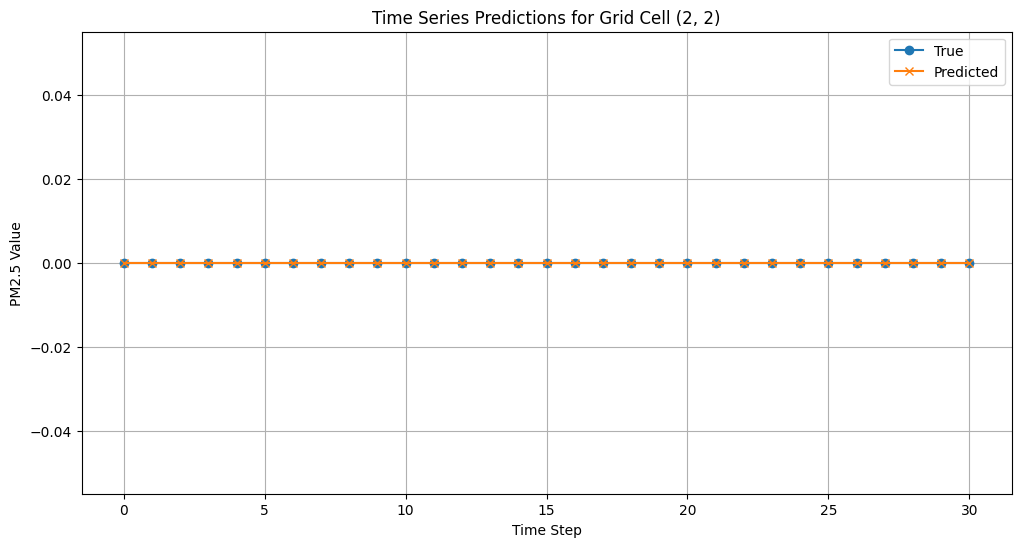

In [87]:
# After model training, add these visualization functions

def plot_training_history(history):
    """Plot training and validation metrics"""
    plt.figure(figsize=(15, 5))
    
    # Plot loss
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot MAE
    plt.subplot(1, 3, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    
    # Plot MSE
    plt.subplot(1, 3, 3)
    plt.plot(history.history['mse'], label='Training MSE')
    plt.plot(history.history['val_mse'], label='Validation MSE')
    plt.title('Model MSE')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_predictions_vs_actual(y_true, y_pred, num_samples=5):
    """Plot predictions vs actual values for multiple samples"""
    plt.figure(figsize=(15, 3*num_samples))
    
    for i in range(num_samples):
        # True values
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(y_true[i], cmap='viridis')
        plt.title(f'True PM2.5 (Sample {i+1})')
        plt.colorbar()
        
        # Predicted values
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(y_pred[i], cmap='viridis')
        plt.title(f'Predicted PM2.5 (Sample {i+1})')
        plt.colorbar()
        
        # Error map
        plt.subplot(num_samples, 3, i*3 + 3)
        error = np.abs(y_true[i] - y_pred[i])
        plt.imshow(error, cmap='hot')
        plt.title(f'Absolute Error (Sample {i+1})')
        plt.colorbar()
    
    plt.tight_layout()
    plt.show()

def plot_error_analysis(y_true, y_pred):
    """Analyze and plot error distribution"""
    # Calculate errors
    errors = y_true - y_pred
    abs_errors = np.abs(errors)
    
    plt.figure(figsize=(15, 5))
    
    # Error distribution
    plt.subplot(1, 3, 1)
    plt.hist(errors.flatten(), bins=50)
    plt.title('Error Distribution')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    
    # Absolute error distribution
    plt.subplot(1, 3, 2)
    plt.hist(abs_errors.flatten(), bins=50)
    plt.title('Absolute Error Distribution')
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')
    
    # Scatter plot of true vs predicted
    plt.subplot(1, 3, 3)
    plt.scatter(y_true.flatten(), y_pred.flatten(), alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.title('True vs Predicted Values')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    
    plt.tight_layout()
    plt.show()

# Make predictions
y_pred = model.predict(X_test)

# Print evaluation metrics
test_loss, test_mae, test_mse = model.evaluate(X_test, y_test, verbose=0)
print("\nModel Evaluation Metrics:")
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test RMSE: {np.sqrt(test_mse):.4f}")

# Plot training history
plot_training_history(history)

# Plot predictions vs actual values
plot_predictions_vs_actual(y_test, y_pred, num_samples=5)

# Plot error analysis
plot_error_analysis(y_test, y_pred)

# Calculate and print additional metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Flatten the arrays for metric calculation
y_true_flat = y_test.reshape(-1)
y_pred_flat = y_pred.reshape(-1)

r2 = r2_score(y_true_flat, y_pred_flat)
mae = mean_absolute_error(y_true_flat, y_pred_flat)
mse = mean_squared_error(y_true_flat, y_pred_flat)
rmse = np.sqrt(mse)

print("\nAdditional Metrics:")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

# Plot time series of predictions for a specific grid cell
def plot_time_series_predictions(y_true, y_pred, grid_cell=(2,2)):
    """Plot time series of predictions for a specific grid cell"""
    plt.figure(figsize=(12, 6))
    
    # Extract time series for the specified grid cell
    true_series = y_true[:, grid_cell[0], grid_cell[1]]
    pred_series = y_pred[:, grid_cell[0], grid_cell[1]]
    
    plt.plot(true_series, label='True', marker='o')
    plt.plot(pred_series, label='Predicted', marker='x')
    plt.title(f'Time Series Predictions for Grid Cell {grid_cell}')
    plt.xlabel('Time Step')
    plt.ylabel('PM2.5 Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot time series for a few grid cells
for i in range(3):
    for j in range(3):
        plot_time_series_predictions(y_test, y_pred, grid_cell=(i,j))